# Final analysis 0

In [1]:
import model_tools

In [2]:
from model_tools import TS, Special_TS
from model_tools import load_data, load_hdf
from model_tools import Visual 
from model_tools import cut, cut_dict 
from model_tools import make_matrix
from model_tools import Load_analysis, Analysis
from model_tools import np
from model_tools import DF

In [3]:
import itertools
from scipy import stats as st 

In [4]:
plot = Visual.plot
plot2 = Visual.plot2
curve = Visual.curve
whiskers = Visual.whiskers
histogram = Visual.histogram
compare = Visual.compare
panel = Visual.panel


In [5]:
# adresy:
# "F:\diplomka\model\data\hdf_final"
# "d:\moje_dokumenty\Desktop\diplomka\model\data\chosen"
# "d:\moje_dokumenty\Desktop\diplomka\model\data\hdf_final"

In [6]:
%cd "d:\moje_dokumenty\Desktop\diplomka\model\data\chosen"

d:\moje_dokumenty\Desktop\diplomka\model\data\chosen


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [7]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [8]:
panels = ("main", "ill", "int_trade", "sentiments",  "yearly", "money", 
          "labor", "profits",  "industry", "cons", "cycles")

In [9]:
pans = {ind: pan for ind, pan in enumerate(panels)}

In [10]:
basic_vs = ["inflation_y",
            "mean_real_wage_m",
            "total_export_rates_m",
            "total_import_rates_m",
            "total_trade_balances_m",
            "excessive_debt_rate_m",
            "firm_sentiment",
            "self_financing_ratio_m",
            "production",
            "prices",
            "total_export_rates_y"]

In [11]:
from model_tools import ratios
import numpy as np
from pandas import DataFrame as DF

In [12]:
def y_to_m(series, final_length = 1380):
    """Prepares yearly data for being plotted againts monthly data."""
    final_series = []
    lin = np.arange(12)
    for s in series:
        final_s = np.empty(final_length)
        final_s[:] = np.nan
        for i, point in enumerate(s[:-1]):
            final_s[12*(i+1):12*(i+2)] = point + (s[i+1] - point)*lin/12
        
        final_series.append(list(final_s))
    return final_series

In [13]:
def find_recs(series, cond = 0.03, percentile = 25, low = None):
    if low is None:
        low = np.percentile(series, percentile)
    ends = []
    starts = []
    depths, lengths = [], []
    i = 0
    ln = len(series)
    while i < ln:
        if series[i] < low:
            start = i
            end = "no"
            while end == "no" and i < (ln-1):
                i += 1
                if series[i] >= low:
                    end = i
            if end == "no":
                end = ln
            
            depth = min(series[start:end])
            if depth < low - cond:
                starts.append(start)
                if end < ln:
                    ends.append(end)
                    depths.append(depth)
                    lengths.append(end - start)
        i += 1
        
    return low, starts, ends, depths, lengths

In [14]:
def BC_synchronization(bc_data1, bc_data2, length = 1380):
    """bc_data = [starts, ends]"""
    series1 = np.zeros(length)
    series2 = np.zeros(length)
    for s, e in zip(*bc_data1):    # identify recessions
        series1[s:e] = 1
    if len(bc_data1[0]) > len(bc_data1[1]):    # if there is recession at the end of simulation
        series1[bc_data1[0][-1]:] = 1
    
    for s, e in zip(*bc_data2):    # identify recessions
        series2[s:e] = 1
    if len(bc_data2[0]) > len(bc_data2[1]):    # if there is recession at the end of simulation
        series2[bc_data2[0][-1]:] = 1
    return (series1, series2), (1-series1, 1-series2)

In [15]:
def round2(value, typ):
    if abs(value) > 2:
        if typ == 1:     # rounding of averages
            return round(value, 1)
        else:           # rounding of stds
            return round(value, 2)
    else:
        if typ == 1:
            return round(value, 4)
        elif typ == 2:
            return round(value, 4)
        else:
            return round(value, 4)

In [16]:
round2_vect = np.vectorize(round2)

In [17]:
def averaging(data_source, variable, subtype = "means", clear = False):
    """Averages time series for a country throughout all the simulations for a country. 
    Assumes the same length of data series."""
    all_mins, all_means, all_maxs, all_stds0, all_stds, all_stds_2 = [], [], [], [], [], []
    for scenario in data_source:
        scen_mins, scen_means, scen_maxs, scen_stds0, scen_stds, scen_stds_2 =  [], [], [], [], [], []
        if subtype == "data":
            no_countries = len(scenario[0][variable])
        elif subtype == "means":
            no_countries = len(scenario[0][variable].means())
        elif subtype == "sums":
            no_countries = len(scenario[0][variable].sums())
        for country in range(no_countries):
            means = []
            stds = []
            for sim in scenario:
                if subtype == "data":
                    data = sim[variable][country]
                elif subtype == "means":
                    data = sim[variable].means()[country]
                elif subtype == "sums":
                    data = sim[variable].sums()[country]
                    
                if clear:
                    data = [x for x in data if x is not None]
                means.append(np.mean(data))                 # same length - mean of averages will be the same as the overall average
                stds.append(np.std(data)) # will take average of individual simulation stds
            scen_mins.append(round2(min(means),1))
            scen_means.append(round2(np.mean(means),1))
            scen_maxs.append(round2(max(means),1))
            scen_stds0.append(round2(np.std(means),2))      # std of averages
            scen_stds.append(round2(np.mean(stds),2))       # average of stds
            scen_stds_2.append(round2(np.std(stds),3))      # std of stds
        all_mins.append(scen_mins)
        all_means.append(scen_means)
        all_maxs.append(scen_maxs)
        all_stds0.append(scen_stds0)
        all_stds.append(scen_stds)
        all_stds_2.append(scen_stds_2)
        
    return all_mins, all_means, all_maxs, all_stds0, all_stds, all_stds_2

In [18]:
def create_folder(path, trial = 0):
    if "os" not in globals():
        global os
        import os
    path2 = path
    if trial > 99:
        print("too many iterations")
        return None
    path2 += "_" + str(trial)
    try:
        os.mkdir(path2)
        return path2
    except:
        return create_folder(path, trial+1)

In [19]:
def markers(starts, ends, low, length = 1380, y_lim = 0.6):
    series = np.empty(length)
    series[:] = np.NaN
    if starts == []:
        return series
    series[starts] = low
    series[np.array(starts) + 1] = y_lim
    if ends == []:
        return series
    series[ends] = low
    series[np.array(ends)-1] = y_lim
    return series

In [20]:
def choose(starts, ends, indeces):
    i, j = indeces
    if len(ends[0]) <= i or len(ends[1]) <= j:
        return "finished", 0, 1
    
    if starts[0][i] > starts[1][j]:
        curr_end = ends[1][j]
        first_cc = 1
        second_cc = 0
    else:
        curr_end = ends[0][i]
        first_cc = 0
        second_cc = 1
    return curr_end, first_cc, second_cc

In [21]:
def connect_alg(starts, ends):
    st_1, st_2 = starts
    ends_1, ends_2 = ends
    if len(ends_1) == 0 or len(ends_2) == 0:
        return [[]]*2
    
    indeces = [0,0]
    crises = [[], []]
    
    curr_end, first_cc, second_cc = choose(starts, ends, indeces)
    
    if curr_end == "finished":
        cont = False
    else:
        cont = True
    curr_crisis = [[],[]]
    
    while cont:
        if curr_end > starts[second_cc][indeces[second_cc]]:   # crises are intersecting
            a, b = indeces
            if len(ends_1) <= a or len(ends_2) <= b:
                
                break
            curr_crisis[0].append(a)
            curr_crisis[1].append(b)
            
                        
            if ends[second_cc][indeces[second_cc]] > curr_end:  # current end shifts to second country
                curr_end = ends[second_cc][indeces[second_cc]]
                indeces[first_cc] += 1
                first_cc, second_cc = second_cc, first_cc
                
            else:                # crisis in second country is inside the first crisis
                indeces[second_cc] += 1
            
            cont = True
        
        else:                 # crises are not intersecting (anymore), we have finished global crisis
            
            indeces[first_cc] += 1
            
            curr_end, first_cc, second_cc = choose(starts, ends, indeces)
            crises[0].append(list(set(curr_crisis[0])))
            crises[1].append(list(set(curr_crisis[1])))
            curr_crisis = [[],[]] 
            cont = True
        
        if curr_end == "finished":
            cont = False
        a, b = indeces
        if len(st_1) <= a or len(st_2) <= b:       # nothing more to compare
            crises[0].append(list(set(curr_crisis[0])))
            crises[1].append(list(set(curr_crisis[1])))
            cont = False
            
    return crises
    

In [22]:
class crisis:
    
    def __init__(self, empl_data_c0, empl_data_c1):
        """Creates global crisis data for an individual simulation."""
        starts = [empl_data_c0[1].copy(), empl_data_c1[1].copy()]
        ends = [empl_data_c0[2].copy(), empl_data_c1[2].copy()]
        depths = [empl_data_c0[3].copy(), empl_data_c1[3].copy()]
        lengths= [empl_data_c0[4].copy(), empl_data_c1[4].copy()]
        
        crisis_indeces = connect_alg(starts, ends)
        
        first_countries = []       # which country is first in recession
        union_periods = []         # at least one country in crises
        union_lengths = []
        #intersection_periods = []  # both countries in crisis
        intersection_lengths = []
        first_depths, first_lengths  = [], []
        second_depths, second_lengths = [], []
        contained_crises = len(ends[0] + ends[1])
        
        for inds_0, inds_1 in zip(*crisis_indeces):
            if len(inds_0) == 0 or len(inds_1) == 0:
                continue
            i, j = inds_0[0], inds_1[0]
            if starts[0][i] <= starts[1][j]:
                first_cc = 0
                second_cc = 1
                first_indeces = inds_0
                second_indeces = inds_1
                overall_start = starts[0][i]
            else:
                first_cc = 1
                second_cc = 0
                first_indeces = inds_1
                second_indeces = inds_0
                overall_start = starts[1][j]
            first_countries.append(first_cc)
            overall_end = max(ends[0][inds_0[-1]], ends[1][inds_1[-1]])
            union_periods.append((overall_start, overall_end))
            union_lengths.append(overall_end - overall_start)
            
            first_depths.append(min([depths[first_cc][ii] for ii in first_indeces]))
            second_depths.append(min([depths[second_cc][ii] for ii in second_indeces]))
            first_lengths.append(sum(lengths[first_cc][ii] for ii in first_indeces))
            second_lengths.append(sum(lengths[second_cc][ii] for ii in second_indeces))
            
            inter_l = first_lengths[-1] + second_lengths[-1] - union_lengths[-1]
            intersection_lengths.append(inter_l)
            
            contained_crises -= len(inds_0+inds_1)
            
        self.first_countries = first_countries
        self.no_global_crises = len(first_countries)
        self.union_periods = union_periods
        self.union_lengths = union_lengths
        #self.intersection_periods = intersection_periods
        self.intersection_lengths = intersection_lengths
        self.depths = (first_depths, second_depths)
        self.lengths = (first_lengths, second_lengths)
        self.contained_crises = contained_crises  
        
        self.no_global_crises_0 = len([i for i in self.first_countries if i == 0])
        self.no_global_crises_1 = len([i for i in self.first_countries if i == 1])
        self.union_periods_0 = [union_periods[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.union_periods_1 = [union_periods[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        self.union_lengths_0 = [union_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.union_lengths_1 = [union_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        #self.intersection_periods = intersection_periods
        self.intersection_lengths_0 = [intersection_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.intersection_lengths_1 = [intersection_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        self.depths_0 = ([self.depths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0],
                         [self.depths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0])
        self.depths_1 = ([self.depths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1],
                         [self.depths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1])
        self.lengths_0 = ([self.lengths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0],
                          [self.lengths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0])
        self.lengths_1 = ([self.lengths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1],
                          [self.lengths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1])
        
    
    def show(self):
        attrs = { 
            "first_cc": self.first_countries,
            "union_periods": self.union_periods,
            "union_lengths": self.union_lengths,
            #"": self.intersection_periods,
            "intersection_lengths": self.intersection_lengths,
            "depths": self.depths,
            "lengths": self.lengths,
            "no_of_global_crises": self.no_global_crises,
            "no_of_contained_crises": self.contained_crises
        }
        return attrs
        

In [23]:
def cut_2(series, starts, ends, period_data = False):
    from copy import deepcopy
    new_s = deepcopy(series)
    if not period_data:        # simply subsetting from a list of series
        no_c = len(series)      # no of countries
        for i in range(no_c):
            for st, en in zip(starts[i], ends[i]):
                if en is None:
                    en = len(series[i])
                try:
                    new_s[i][st:en] = [None]*(en-st)
                except:
                    new_s = [list(ss) for ss in new_s]
                    new_s[i][st:en] = [None]*(en-st)
    else:             # subsetting from pairs or more
        no_c = len(series[0])      # no of countries
        #no_v = len(series[0][0])   # no of statistics in series
        if isinstance(new_s[0][0], np.ndarray):
            for per, junk in enumerate(new_s):
                new_s[per] = list(new_s[per])
                for ii, jj in enumerate(junk):
                    new_s[per][ii] = list(new_s[per][ii])
        for i in range(no_c):
            if isinstance(new_s[0][i], list): #or isinstance(new_s[0][i], np.ndarray):
                for st, en in zip(starts[i], ends[i]): 
                    for j, period_point in enumerate(new_s[st:en]):
                        new_s[st:en][j][i] = [None]*len(period_point[i]) 
            else:
                for st, en in zip(starts[i], ends[i]): 
                    for j, period_point in enumerate(new_s[st:en]):
                        new_s[st:en][j][i] = None
                    
    return new_s

In [24]:
def cut_dict_2(*data_dicts, starts, ends, crises = True, variables = "all"):
    """Subsets either stability or crises periods from chosen time series in each data dictionary."""
    from copy import deepcopy
    result = []
    for i, data_dict in enumerate(data_dicts):
        if crises:
            curr_starts = [[0] + ee for ee in ends[i]]
            curr_ends = [st + [None] for st in starts[i]]
        else:
            curr_starts = starts[i]
            curr_ends = ends[i]
        new_dict = {}
        if variables == "all":
            variables = list(data_dict.keys())
        for key in variables:
            if key == "bank_bankruptcies":
                new_dict[key] = deepcopy(data_dict[key])
                continue
            #print(key)
            if key[-2:] == "_y":             # for yearly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    now_starts = [int(st/12) for st in curr_starts]
                    now_ends = [int(en/12) for en in curr_ends if en is not None] + [None]
                    new_dict[key].data = cut_2(new_dict[key].data, now_starts, now_ends, period_data = 1)
                except:
                    now_starts = [[int(st/12) for st in substarts] for substarts in curr_starts]
                    now_ends = [[int(en/12) for en in subends if en is not None] + [None] for subends in curr_ends]
                    new_dict[key] = cut_2(data_dict[key], now_starts, now_ends, period_data = 0)
            
            else:                           # for the rest, ie monthly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    new_dict[key].data = cut_2(new_dict[key].data, curr_starts, curr_ends, period_data = 1)
                except:
                    new_dict[key] = cut_2(data_dict[key], curr_starts, curr_ends, period_data = 0)
        result.append(new_dict)
    return result

In [25]:
def concat_lat(lats, descrpits, measure = None, country = None, kind = 0):
    lat = lats[0]
    if kind == 0:                          # for averages data
        final = lat[:lat.find("country 0")]
    elif kind == 1:                                  # for recessions data
        final = lat[:lat.find(str(measure) + " C" + str(country))]
    else:
        final = lat[:lat.find(str(measure))]
    for lat, des in zip(lats, descrpits):
        ii = final.find("end{tabular}") - 1
        if ii > 0:
            final = final[:ii]
        if kind == 0:
            final += des + " & & & & & & \\\\\n "
        else:
            final += des + " & & & & & \\\\\n "
        
        jj = lat.find("\midrule")
        final += lat[jj:]
    return final

In [26]:
def add_label(table, label):
    ii = table.find("\\end{table}")
    label = label.replace("\\", " ")
    label = label.replace("_", " ")
    final = table[:ii] + "\label{tab:" + label + "}\n" + table[ii:]
    return final

In [27]:
class Load_analysis:
    def __init__(self, no_countries, name, last, first = 1, cut_start = 120, cut_end = None,
                scenario_names = None, limit = None, variables = "all"):
        """name, scenario_names as string; others as integers"""
        
        nn = name.split("_")
        nn.remove("final")
        self.name = " ".join(nn)
        self.first = first
        self.last = last
        self.cut_start = cut_start
        self.cut_end = cut_end
                
        self.data_list = []
        self.pars_list = []
        self.files_list = []
        for s in range(first, last):
            path = str(no_countries) + "*" + name + str(s) + '.h5'
            dat, fil, par = load_hdf(path, condition = None,  ret_parameters = True, limit = limit, variables = variables)
            for sim in dat:
                try:
                    sim["real_trade_fees"] = ratios(sim["spec_trade_fees"].sums(), sim["price_level_m"])  # add real trade fees
                except:
                    pass
            self.data_list.append(cut_dict(*dat, start = cut_start, end = cut_end))
            self.pars_list.append(par)
            self.files_list.append(fil)
            
        try:
            self.firsts = [scenario[0] for scenario in self.data_list]
        except:   # when creating empty load object
            self.firsts = []
        self.no_scens = len(self.data_list)
        self.no_countries = [no_countries]*self.no_scens
        if scenario_names is None:
            self.scenario_names = [str(i) for i in range(self.no_scens)]
        else:
            self.scenario_names = scenario_names

In [28]:
class Analysis:
       
    def __init__(self, load_obj):
        self.name = load_obj.name 
        self.first = load_obj.first
        self.last = load_obj.last
        self.cut_start = load_obj.cut_start
        self.cut_end = load_obj.cut_end
        self.scenario_names = load_obj.scenario_names.copy()
        self.no_countries = load_obj.no_countries.copy()
        self.data_list = load_obj.data_list.copy()
        self.pars_list = load_obj.pars_list.copy()
        self.files_list = load_obj.files_list.copy()
        self.firsts = load_obj.firsts.copy()
        self.no_scens = load_obj.no_scens
        
        self.correlations = {}.copy()
        self.ind_correlations = {}.copy()
        self.stab_data_list = []
        self.stab_data_list_pars = []
        self.crises_data_list = []
        self.crises_data_list_pars = []
        
    def find_sim(self, name):
        """Returns data for the simulation based on its name."""
        for i, scenario in enumerate(self.pars_list):
            for j, sim in enumerate(scenario):
                if sim["name"][0] == name:
                    print(i, j)
                    return self.data_list[i][j], i, j
        print("not found")
        return "not found"
    
    def concatenate(self, load_obj, name = None):
        """Concatenate with another loaded dataset."""
        if name is None:
            self.name += " " + load_obj.name
        else:
            self.name = name
        # first, last, cut_start/end remains unchanged
        self.scenario_names.extend(load_obj.scenario_names)
        self.no_countries.extend(load_obj.no_countries)
        self.data_list.extend(load_obj.data_list)
        self.pars_list.extend(load_obj.pars_list)
        self.files_list.extend(load_obj.files_list)
        self.firsts.extend(load_obj.firsts)
        self.no_scens += load_obj.no_scens
        
    def subset(self, scenarios, name = None):
        """Creates load object containing chosen scenarios."""
        sub_obj = Load_analysis(0,"empty_final_empty", 0, 0)
        if name is None:
            sub_obj.name = self.name
        else:
            sub_obj.name = name
        # first, last remain as in empty load object
        sub_obj.cut_start = self.cut_start
        sub_obj.cut_end = self.cut_end
        sub_obj.scenario_names = [self.scenario_names[i] for i in scenarios]
        sub_obj.no_countries = [self.no_countries[i] for i in scenarios]
        sub_obj.data_list = [self.data_list[i] for i in scenarios]
        sub_obj.pars_list = [self.pars_list[i] for i in scenarios]
        sub_obj.files_list = [self.files_list[i] for i in scenarios]
        sub_obj.firsts = [self.firsts[i] for i in scenarios]
        sub_obj.no_scens = len(scenarios)
        return sub_obj
    
    def make_pars_dicts(self):
        """Works for standardly loaded objects."""
        name = self.name.split(" ")
        if name[0] in ["BB", "MM"]:
            no = 4
            ns = [ [5000,5000]]*no
            res = [[12, 12], [8,8], [12,8], [12,8]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.05,0.25]]
        else:
            no = 6
            ns = [ [8000,2000]]*no
            res = [[12, 12], [8,8], [12,8], [8,12], [12,8], [8,12]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.08, 0.05], [0.05,0.25], [0.25,0.05]]
    
        if name[1] == "base":
            costs = [str(make_matrix(0.2, True))]*no
        elif name[1] == "nc":
            costs = [str(make_matrix(0, True))]*no
        else:
            if name[0] in ["BB", "MM"]:
                costs = [str(make_matrix(0.7, True))]*no
            else:
                costs = [str(make_matrix(0.4, True))]*no
    
        if name[-2] == "free":
            quotas = [str(make_matrix(1))]*no
            free_m = [True]*no
        elif name[-2] == "med":
            quotas = [str(make_matrix(0.3))]*no
            free_m = [False]*no
        else:
            quotas = [str(make_matrix(0.05))]*no
            free_m = [False]*no
    
        if name[2] == "pegged":
            pegs = [[-1, 0]]*no
        else:
            pegs = [[-1, -1]]*no
            
           
        dicts = [{"ns": ns[i], "wage_resist": res[i], "wage_flex": flex[i], 
              "trade_costs": costs[i], 'trade_quotas': quotas[i], "free_market": free_m[i],
             'pegged_rates': pegs[i], "transport_firms": 2} for i in range(self.first-1, self.last-1)]
        return dicts
        
    def test_parameters(self, pars_dicts = "default"):
        """Default works for standardly loaded objects."""
        errors = []
        if pars_dicts == "default":
            pars_dicts = self.make_pars_dicts()
        for i, pars_dict in enumerate(pars_dicts):
            for par in pars_dict:
                for j, sim in enumerate(self.pars_list[i]):
                    value = sim[par][0].split("= ")[-1]
                    if str(pars_dict[par]) != value:
                        errors.append("scenario " + str(i) + " simulation " + str(j) + ": " + par)
        self.pars_errors = errors
        return errors

    
    def analyze_recs(self, recs_cond = 0.03, recs_percentile = 25, general = True):
        """Analyze recessions."""
        self.empl_borders = []           # scenario->country->simulation
        self.empl_data = []              # scenario->country->simulation
        self.BC_synchronizations = []    # scenario->country->simulation
        self.general_low = general
        self.ind_borders = []
        self.recs_indicators = []
        self.stab_indicators = []
        
        for ii, scenario in enumerate(self.data_list):    # go scenario by scenario
            recs_borders = []
            recs_scen_ind_borders = []
            recs_scenario_data = []
            empl_sync = []
            
            for cc in range(self.no_countries[ii]):   # go country by country
                recs_data = []
                if general:                       # area of stability shared across all simulations in a scenario
                    percs = [np.percentile(sim["employment"].means()[cc], recs_percentile) for sim in scenario]
                    low = np.mean(percs)                     # find border of area of stability
                    #recs_borders.append((low, np.std(percs)))  
                    recs_borders.append((round2(low,1),round2(min(percs),1),round2(np.median(percs),1),
                                    round2(max(percs),1), round2(np.std(percs),2)))
                    recs_scen_ind_borders.append(percs)
                    
                for sim in scenario:          # go simulation by simulation
                    series = sim["employment"].means()[cc]
                    if not general:               # simulation-specific area of stability
                        low = np.percentile(series, recs_percentile)
                        
                    # find_recs gives stability border, and recessions' starts, ends, depths, and lengths 
                    recs_data.append(find_recs(series, recs_cond, recs_percentile, low = low))  # find recessions
                    if cc == 0:
                        if self.no_countries[ii] == 2:
                            empl_sync.append(np.corrcoef(sim["employment"].means())[0][1])
                        else:
                            empl_sync.append(np.corrcoef(sim["employment"].means()))                ### work out differently 
                recs_scenario_data.append(recs_data)
            
            self.ind_borders.append(recs_scen_ind_borders)
            self.empl_borders.append(recs_borders)
            self.empl_data.append(recs_scenario_data)
            if self.no_countries[ii] == 2:
                all_indicators = [BC_synchronization(recs_scenario_data[0][sim][1:3], recs_scenario_data[1][sim][1:3]) 
                            for sim in range(len(scenario))]
                indicators = [inds[0] for inds in all_indicators]
                anti_indicators = [inds[1] for inds in all_indicators]
                rec_sync = [np.corrcoef(ind)[0][1] for ind in indicators]
                self.recs_indicators.append(indicators)
                self.stab_indicators.append(anti_indicators)
                self.BC_synchronizations.append((round2(np.nanmean(rec_sync),1),round2(np.nanmin(rec_sync),1),
                                                 round2(np.nanmedian(rec_sync),1),
                                                 round2(np.nanmax(rec_sync),1), round2(np.nanstd(rec_sync),2)))
            else:
                pass
                #self.BC_synchronizations.append([(np.mean(empl_sync, axis = 0), np.std(empl_sync, axis = 0))])
        
        self.recs_depths, self.recs_lengths, self.recs_count = [], [], []
        self.recs_time = []
        self.recs_ind_data = []
        self.recs_ind_data_t = []    # used for t-tests
        self.recs_depths_t, self.recs_lengths_t = [], []
        for scenario in self.empl_data:
            scen_depths, scen_lengths, scen_count = [], [], []   # everything for only finished recessions
            scen_time = []
            scen_recs_ind_data = []
            scen_recs_ind_data_t = []  # used for t-tests
            scen_depths_t, scen_lengths_t = [], []
            for country in scenario:
                lengths, time = [], []
                lengths_t, depths_t = [], []    # used for t-tests
                depths, count = [], []
                for sim in country:
                    lengths.extend(sim[4])
                    lengths_t.append(np.mean(sim[4]))    # used for t-tests
                    depths.extend(sim[3])
                    depths_t.append(np.mean(sim[3]))    # used for t-tests
                    count.append(len(sim[2])) 
                    time.append(sum(sim[4]))    
                scen_depths.append((round2(np.mean(depths),1),round2(min(depths),1),round2(np.median(depths),1),
                                    round2(max(depths),1), round2(np.std(depths),2)))
                scen_lengths.append((round2(np.mean(lengths),1), round2(min(lengths),1), round2(np.median(lengths),1), 
                                     round2(max(lengths),1), round2(np.std(lengths),2)))
                scen_count.append((round2(np.mean(count),1), round2(min(count),1), round2(np.median(count),1),
                                   round2(max(count),1), round2(np.std(count),2)))
                scen_time.append((round2(np.mean(time),1), round2(min(time),1),round2(np.median(time),1),
                                  round2(max(time),1), round2(np.std(time),2)))
                
                scen_depths_t.append((round2(np.nanmean(depths_t),1),round2(np.nanmin(depths_t),1),round2(np.nanmedian(depths_t),1),
                                    round2(np.nanmax(depths_t),1), round2(np.nanstd(depths_t),2)))
                scen_lengths_t.append((round2(np.nanmean(lengths_t),1), round2(np.nanmin(lengths_t),1), round2(np.nanmedian(lengths_t),1), 
                                     round2(np.nanmax(lengths_t),1), round2(np.nanstd(lengths_t),2)))
                
                scen_recs_ind_data.append([depths, lengths, time, count])
                scen_recs_ind_data_t.append([depths_t, lengths_t])    # used for t-tests
                
            self.recs_ind_data.append(scen_recs_ind_data)
            self.recs_ind_data_t.append(scen_recs_ind_data_t)    # used for t-tests
            
            self.recs_depths.append(scen_depths)
            self.recs_lengths.append(scen_lengths)
            self.recs_count.append(scen_count)
            self.recs_time.append(scen_time)
            
            self.recs_depths_t.append(scen_depths_t)
            self.recs_lengths_t.append(scen_lengths_t)
        
            
            
    def make_global_crises(self):
        self.global_crises = []
        all_depths, all_lengths, all_time, all_count = [], [], [], []
        all_depths_0, all_lengths_0, all_time_0, all_count_0 = [], [], [], []
        all_depths_1, all_lengths_1, all_time_1, all_count_1 = [], [], [], []
        for scenario in self.empl_data:
            scen_crises = []
            depths, lengths, time, count = [[],[]], [[],[]], [[],[]], [[],[]]
            depths_0, lengths_0, time_0, count_0 = [[],[]], [[],[]], [[],[]], [[],[]]
            depths_1, lengths_1, time_1, count_1 = [[],[]], [[],[]], [[],[]], [[],[]]
            if len(scenario) != 2:
                continue
            for sim_data_0, sim_data_1 in zip(*scenario):
                glob_cr = crisis(sim_data_0, sim_data_1)
                scen_crises.append(glob_cr)
                
                depths[0].extend(glob_cr.depths[0])
                depths[1].extend(glob_cr.depths[1])
                lengths[0].extend(glob_cr.lengths[0])
                lengths[1].extend(glob_cr.lengths[1])
                time[0].append(sum(glob_cr.lengths[0]))
                time[1].append(sum(glob_cr.lengths[1]))
                count[0].append(glob_cr.no_global_crises)
                count[1].append(glob_cr.contained_crises)
                
                depths_0[0].extend(glob_cr.depths_0[0])
                depths_0[1].extend(glob_cr.depths_0[1])
                lengths_0[0].extend(glob_cr.lengths_0[0])
                lengths_0[1].extend(glob_cr.lengths_0[1])
                time_0[0].append(sum(glob_cr.lengths_0[0]))
                time_0[1].append(sum(glob_cr.lengths_0[1]))
                count_0[0].append(glob_cr.no_global_crises_0)
                count_0[1].append(glob_cr.no_global_crises_1)
                
                depths_1[0].extend(glob_cr.depths_1[0])
                depths_1[1].extend(glob_cr.depths_1[1])
                lengths_1[0].extend(glob_cr.lengths_1[0])
                lengths_1[1].extend(glob_cr.lengths_1[1])
                time_1[0].append(sum(glob_cr.lengths_1[0]))
                time_1[1].append(sum(glob_cr.lengths_1[1]))
                count_1[0].append(glob_cr.no_global_crises_0)
                count_1[1].append(glob_cr.no_global_crises_1)
                
            self.global_crises.append(scen_crises)
            all_depths.append(depths)
            all_lengths.append(lengths)
            all_time.append(time)
            all_count.append(count)
            
            all_depths_0.append(depths_0)
            all_lengths_0.append(lengths_0)
            all_time_0.append(time_0)
            all_count_0.append(count_0)
            
            all_depths_1.append(depths_1)
            all_lengths_1.append(lengths_1)
            all_time_1.append(time_1)
            all_count_1.append(count_1)
            
        self.global_crises_aggr = [all_depths, all_lengths, all_time, all_count]
        self.global_crises_aggr_0 = [all_depths_0, all_lengths_0, all_time_0, all_count_0]
        self.global_crises_aggr_1 = [all_depths_1, all_lengths_1, all_time_1, all_count_1]
        
        
    def make_stab_data_list(self, scenarios = "all", countries = "all", sims = "all", 
                            crises = False, variables = "all", quick = False, refresh = False):
        """Creates subsets of data excluding or only including crises periods."""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if sims == "all":
            sims = [[i for i, sim in enumerate(self.data_list[scen])] for scen in scenarios]
        if quick:
            self.quick_data_list = []
            
        if refresh:
            if crises:
                self.crises_data_list, self.crises_data_list_pars = [], []
            else:
                self.stab_data_list, self.stab_data_list_pars = [], []
        for sc_i, scen in enumerate(scenarios):
            starts, ends = [], []
            for s in sims[sc_i]:
                curr_starts = [self.empl_data[scen][cc][s][1] for cc in countries[scen]] 
                curr_ends = [self.empl_data[scen][cc][s][2] for cc in countries[scen]] 
                starts.append(curr_starts) 
                ends.append(curr_ends)
            new_datas = cut_dict_2(*self.data_list[scen], starts = starts, ends = ends, 
                                   crises = crises, variables = variables)
            
            if quick:
                self.quick_data_list.append(new_datas)
            elif not crises:
                self.stab_data_list.append(new_datas)
                self.stab_data_list_pars.append({"scen": scen, "sims": sims[sc_i], 
                                                "countries": countries[scen], "vs": variables})
            else:
                self.crises_data_list.append(new_datas)
                self.crises_data_list_pars.append({"scen": scen, "sims": sims[sc_i], 
                                                 "countries": countries[scen], "vs": variables})
        
        
        
    def get_averages(self, variables = "all", data = "original"):
        """Calculates averages,stds and stds-of-stds of interesting time series.
        For "all" option assumes same variables across scenarios."""
        averages = {}
        if data in [0, "original"]:
            clear = False
            data_source = self.data_list
        elif data in [1, "stab"]:
            clear = True
            data_source = self.stab_data_list
        elif data in [2, "crises"]:
            clear = True
            data_source = self.crises_data_list
        elif data in [3, "quick"]:
            clear = True
            data_source = self.quick_data_list
        else:
            clear = True
            data_source = data
        
        if variables == "all":
            variables = data_source[0][0]
        
        for key in variables:
            try:
                averages[key] = averaging(data_source, key, "means", clear = clear)
            except:
                try:
                    averages[key] = averaging(data_source, key, "data", clear = clear)
                except:
                    averages[key] = averaging(data_source, key, "sums", clear = clear)
        if data in [0, "original"]:
            self.averages = averages
        elif data in [1, "stab"]:
            self.stab_averages = averages
        elif data in [2, "crises"]:
            self.crises_averages = averages
        elif data in [3, "quick"]:
            self.quick_averages = averages
        else:
            self.special_averages = averages
    
    def make_correlations(self, var1, var2 = None, type1 = "sums", type2 = "sums",
                          across = True, countries = "all", scenarios = "all", sims = "all",
                         save = False):
        """Option "across" for scenarios with 2 countries only. Scenarios are used for indexing simulations."""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if sims == "all":
            sims = [[i for i, sim in enumerate(self.data_list[scen])] for scen in scenarios]
            
        all_ind_corrs = [[] for sc in range(self.no_scens)]
        corrs_stats = [[] for sc in range(self.no_scens)]
        
        for sc_i, scen in enumerate(scenarios):
            scen_corrs = []
            for sim in sims[sc_i]:
                sim_data = self.data_list[scen][sim]
                if across:
                    if type1 == "data":
                        corr = np.corrcoef(sim_data[var1])[1][0]
                    elif type1 == "means":
                        corr = np.corrcoef(sim_data[var1].means())[1][0]
                    elif type1 == "sums":
                        corr = np.corrcoef(sim_data[var1].sums())[1][0]
                    
                else:
                    if type1 == "data":
                        v1s = sim_data[var1] 
                    elif type1 == "means":
                        v1s = sim_data[var1].means()
                    elif type1 == "sums":
                        v1s = sim_data[var1].sums()
                    if type2 == "data":
                        v2s = sim_data[var2] 
                    elif type2 == "means":
                        v2s = sim_data[var2].means()
                    elif type2 == "sums":
                        v2s = sim_data[var2].sums()
                    corr = [np.corrcoef(v1s[cc], v2s[cc])[1][0] for cc in countries[scen]]
                scen_corrs.append(corr) 
            if across:
                all_ind_corrs[scen] = round2_vect(scen_corrs,1)
            else:
                countrywise = [[sim[cc] for sim in scen_corrs] for cc in countries[scen]]
                all_ind_corrs[scen] = round2_vect(countrywise,1)
            stats = (round2_vect(np.mean(scen_corrs, axis = 0),1), round2_vect(np.min(scen_corrs, axis = 0),1), 
                        round2_vect(np.median(scen_corrs, axis = 0),1), round2_vect(np.max(scen_corrs, axis = 0),1), 
                        round2_vect(np.std(scen_corrs, axis = 0),2))
            if across:
                corrs_stats[scen] = [float(st) for st in stats]
            else:
                countrywise_stats = [[stat[cc] for stat in stats] for cc in countries[scen]]
                corrs_stats[scen] = countrywise_stats
        if across:
            var2 = type1
        if save:
            self.ind_correlations[var1 + "-" + var2] = all_ind_corrs
            self.correlations[var1 + "-" + var2] = corrs_stats
        return all_ind_corrs, corrs_stats     
    
    def make_BC_indi_metrics(self): 
        metric = lambda ind1, ind2: sum([1 for res in ind1+ind2 if res == 2])/sum(ind1)
        indi_measures_0 = [[metric(sim[0],sim[1]) for sim in scenario] for scenario in self.recs_indicators]
        indi_measures_1 = [[metric(sim[1],sim[0]) for sim in scenario] for scenario in self.recs_indicators]
        indi_measures = [[min([meas_0,meas_1]) for meas_0, meas_1 in zip(scenario1, scenario2)] 
                         for scenario1, scenario2 in zip(indi_measures_0,indi_measures_1)]
        indi_measures_avg = [[sum([meas_0,meas_1])/2 for meas_0, meas_1 in zip(scenario1, scenario2)] 
                         for scenario1, scenario2 in zip(indi_measures_0,indi_measures_1)]
        self.BC_indi_metrics = [(round2(np.nanmean(scenario),1),round2(np.nanmin(scenario),1),
                                round2(np.nanmedian(scenario),1), round2(np.nanmax(scenario),1), 
                                round2(np.nanstd(scenario),2)) for scenario in indi_measures]
        self.BC_indi_metrics_0 = [(round2(np.nanmean(scenario),1),round2(np.nanmin(scenario),1),
                                round2(np.nanmedian(scenario),1), round2(np.nanmax(scenario),1), 
                                round2(np.nanstd(scenario),2)) for scenario in indi_measures_0]
        self.BC_indi_metrics_1 = [(round2(np.nanmean(scenario),1),round2(np.nanmin(scenario),1),
                                round2(np.nanmedian(scenario),1), round2(np.nanmax(scenario),1), 
                                round2(np.nanstd(scenario),2)) for scenario in indi_measures_1]
        self.BC_indi_metrics_avg = [(round2(np.nanmean(scenario),1),round2(np.nanmin(scenario),1),
                                round2(np.nanmedian(scenario),1), round2(np.nanmax(scenario),1), 
                                round2(np.nanstd(scenario),2)) for scenario in indi_measures_avg]
        self.indi_measures_0 = indi_measures_0
        self.indi_measures_1 = indi_measures_1
            
    def analyze_all(self, recs_cond = 0.03, recs_percentile = 25, complete = True):
        """Analyze everything."""
        self.analyze_recs(recs_cond, recs_percentile)
        self.make_global_crises()
        self.get_averages()
        self.make_BC_indi_metrics()
        if complete:
            basic_vs = ["inflation_y", "mean_real_wage_m", "total_export_rates_m",
                        "total_import_rates_m", "total_trade_balances_m", "excessive_debt_rate_m",
                        "firm_sentiment", "self_financing_ratio_m", "production",
                        "prices", "total_export_rates_y"]
            self.make_stab_data_list(variables = basic_vs)
            self.make_stab_data_list(variables = basic_vs, crises = True)
            self.get_averages(data = 1)
            self.get_averages(data = 2)
            
    
    def plot_recs(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.75,  length = 1380,
                  marker = "-", grid = True, size = (10,4),
                  x_label = "month", y_label = "employment rate", 
                  titles = None, legends = None,
                  use_plot2 = True, y2_lim = [-0.1, 0.4], y2_label = "inflation rate", marker2 = "-",
                  path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                if use_plot2:
                    infl =  y_to_m(self.data_list[scenario][simulation]["inflation_y"], length)
                else:
                    infl = [np.array(cc)+1 for cc in y_to_m(self.data_list[scenario][simulation]["inflation_y"], length)]
                for cc_i, country in enumerate(countries[scenario]):
                    infl_now = infl[country]
                    empl = self.data_list[scenario][simulation]["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    bb = self.data_list[scenario][simulation]["bank_bankruptcies"][country][0]
                    if bb is False:
                        marks2 = markers([],[],1)
                    else:
                        marks2 = markers([bb],[],1, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "crises, " + self.scenario_names[scenario] + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    
                    if legends is None:
                        if use_plot2:
                            legend1 = ["employment rate", "crisis borders", "bank bankruptcy"]
                            legend2 = ["yearly inflation"]
                        else:
                            legend = ["employment rate", "yearly inflation", "crisis borders", "bank bankruptcy"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                        if use_plot2:
                            legend1 = legend[:-1]
                            legend2 = legend[-1:]
                    
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    
                    if use_plot2: 
                        plot2([empl]  + [marks] + [marks2], marker = marker,
                              title = title, legend = legend1,
                              grid = grid,  size = size,
                              x_label = x_label, y_label = y_label,
                              series2 = [infl_now], y2_label = y2_label,
                              y2_lim = y2_lim, legend2 = legend2, marker2 = marker2,
                              path = path2)
                    else:
                        plot([empl] + [infl_now] + [marks] + [marks2], marker = marker,
                         title = title, legend = legend, 
                         grid = grid,  size = size,
                         x_label = x_label, y_label = y_label,
                         path = path2)
                    
    def plot_recovery(self, scenarios = "all", sims = [0], countries = "all", 
                      y_lim = 0.6,  length = 1380,
                      marker = "-", grid = True, size = (10,4),
                      x_label = "month", y_label = "value", 
                      titles = None, legends = None,
                      use_plot2 = True,  y_lim_plot2 = [0.7, 1.1], y2_lim = [0.1, 1.4],
                      y2_label = "exc. debt rate/mean-divided real wage", marker2 = "-",
                      path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                for cc_i, country in enumerate(countries[scenario]):
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    wage = self.data_list[scenario][simulation]["mean_real_wage_m"][country]
                    wage_rate = np.array(wage)/np.mean(wage)
                    exports = self.data_list[scenario][simulation]["total_export_rates_m"][country]
                    export_rate = np.array(exports)/np.mean(exports)
                    
                    imports = self.data_list[scenario][simulation]["total_import_rates_m"][country]
                    import_rate = np.array(imports)/np.mean(imports)
                    tbs = self.data_list[scenario][simulation]["total_trade_balances_m"][country]
                    tbs_rate = np.array(tbs)/np.mean(np.abs(tbs))
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "recovery plot, " + str(self.scenario_names[scenario]) + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    if legends is None:
                        if use_plot2:
                            legend1 = ["employment r.", "crisis borders"]
                            legend2 = ["exc. debt rate", "mean-divided real wage"]
                        else:
                            legend = ["employment r.", "exc. debt rate", "mean-divided real wage", "crisis borders"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                        if use_plot2:
                            legend1 = legend[0:2]
                            legend2 = legend[2:]
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    
                    if use_plot2: 
                        if y_label == "value":
                            y_label = "employment rate"
                        plot2([empl]  #+ [tbs_rate] +[export_rate] + [import_rate]
                              + [marks] , marker = marker, grid = grid, title = title, y_lim = y_lim_plot2,
                              legend = legend1, size = size, x_label = x_label, y_label = y_label,
                              series2 = [data_dict["excessive_debt_rate_m"][country]] + [wage_rate],
                              legend2 = legend2, y2_lim = y2_lim, y2_label = y2_label, marker2 = marker2,
                              path = path2)
                    else:
                        plot([empl] + [data_dict["excessive_debt_rate_m"][country]] +
                         [wage_rate] #+ [tbs_rate] +[export_rate] + [import_rate]
                         + [marks] , marker = marker, grid = grid, title = title, 
                         legend = legend, size = size, x_label = x_label, y_label = y_label,
                         path = path2)
    
    def plot_deleveraging(self, scenarios = "all", sims = [0], countries = "all", 
                          y_lim = 0.1,  length = 1380,
                          marker = "-", grid = True, size = (10,4),
                          x_label = "month", y_label = "value", 
                          titles = None, legends = None,
                          use_plot2 = True,  y_lim_plot2 = [0.7, 1.1], y2_lim = [0.1, 1.4],
                          y2_label = "firm optimism/self-fin. r./exc. debt r.", marker2 = "-",
                          path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                for cc_i, country in enumerate(countries[scenario]):
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "deleveraging plot, " + str(self.scenario_names[scenario]) + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    if legends is None:
                        if use_plot2:
                            legend1 = ["employment r.", "crisis borders"]
                            legend2 = ["firm optimism", "self-fin. ratio", "exc. debt rate"]
                        else:
                            legend = ["employment r.", "firm optimism", "self-fin. ratio", "exc. debt rate", "crisis borders"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                        if use_plot2:
                            legend1 = legend[:2]
                            legend2 = legend[2:]
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                        
                    if use_plot2:
                        if y_label == "value":
                            y_label = "employment rate"
                        plot2([empl]+ [marks],
                             series2 = [data_dict["firm_sentiment"].means()[country]] 
                             + [data_dict["self_financing_ratio_m"][country]] + [data_dict["excessive_debt_rate_m"][country]],
                             marker = marker, grid = grid, title = title, legend = legend1,
                             x_label = x_label, y_label = y_label, size = size, y_lim = y_lim_plot2,
                             legend2 = legend2, y2_lim = y2_lim, y2_label = y2_label, marker2 = marker2,
                             path = path2)
                    else:
                        plot([empl] + [data_dict["firm_sentiment"].means()[country]] 
                         + [data_dict["self_financing_ratio_m"][country]] + [data_dict["excessive_debt_rate_m"][country]]
                         + [marks] , marker = marker, grid = grid, title = title,
                         x_label = x_label, y_label = y_label, size = size,
                         legend = legend, path = path2)
                    
    def plot_trading(self, scenarios = "all", sims = [0], countries = "all",
                     y_lim = 0.7,  length = 1380,
                     marker = "-", grid = True, size = (10,4),
                    x_label = "month", y_label = "value", 
                    titles = None, legends = None,
                    use_plot2 = True,  y2_lim = [-0.5, 0.1], y_lim_plot2 = [0.7, 1],
                    y2_label = "trade balances/consumption", marker2 = "-",
                    path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate([scen for scen in scenarios if self.no_countries[scen] > 1]): 
            for sim_i, simulation in enumerate(sims):
                data_dict = self.data_list[scenario][simulation]
                trade0 = ratios(data_dict["total_trade_balances_m"], data_dict["cons"].sums())
                if use_plot2:
                    trade = [trade0[cc] for cc in countries[scenario]]
                else:
                    trade = [np.array(trade0[cc])+1 for cc in countries[scenario]]
                empl0 = data_dict["employment"].means()
                empl = [empl0[cc] for cc in countries[scenario]]
                marks_list = []
                for cc in countries[scenario]:
                    low, sts, ends = self.empl_data[scenario][cc][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    marks_list.append(marks)
                if titles is None:
                    title = "trading/cycles plot, " + str(self.scenario_names[scenario]) 
                else:
                    title = titles[sc_i][sim_i]
                if legends is None:
                    if use_plot2:
                        legend1 = ["employment C" + str(cc) for cc in countries[scenario]] + \
                        ["crisis borders C" + str(cc) for cc in countries[scenario]]  
                        legend2 = ["trade bal./consumption C" + str(cc) for cc in countries[scenario]]
                    else:
                        legend = ["employment C" + str(cc) for cc in countries[scenario]] + \
                        ["trade bal./consumption C" + str(cc) for cc in countries[scenario]] + \
                        ["crisis borders C" + str(cc) for cc in countries[scenario]]    
                else:
                    legend = legends[sc_i][sim_i]
                        
                if path is None:
                    path2 = path
                else:
                    path2 = path[:iii] + "_" + str(scenario) + path[iii:]
                
                if use_plot2:
                    if y_label == "value":
                        y_label = "employment rate"
                    plot2(empl  + marks_list, series2 = trade,
                          marker = marker, grid = grid, title = title,
                          x_label = x_label, y_label = y_label, size = size, legend = legend1, y_lim = y_lim_plot2,
                          legend2 = legend2, y2_lim = y2_lim, y2_label = y2_label, marker2 = marker2,
                          path = path2)
                else:
                    plot(empl + trade + marks_list, marker = marker, grid = grid, title = title,
                         x_label = x_label, y_label = y_label, size = size,
                         legend = legend, path = path2)
                
    def recs_whiskers(self, measure = "lengths", scenarios = "all", countries = "all", 
                      global_crises = False, piecewise = False, 
                      labels = "default", y_label = None, 
                      title = "default", size = (12,5), path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if title == "default":
            last_term = measure
            if measure == "depths":
                last_term = "bottoms"
            title = self.name + "crises " + last_term
            if global_crises:
                title = self.name + "global crises " + last_term
        if y_label is None:
            y_label = "crises " + measure
            if measure == "depths":
                y_label = "crises bottoms"
        if labels == "default":
            labels = [str(self.scenario_names[scen]) + ", C" + str(cc) for scen in scenarios for cc in countries[scen]]
            if global_crises:
                if piecewise:
                    labels_0 = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                [" C0 is first in crisis", " C1 is second in crisis"]]
                    labels_1 = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                [" C1 is first in crisis", " C0 is second in crisis"]]
                    if measure == "count":
                        labels = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                  [" C0 is first in crisis", " C1 is second in crisis"]]
                    else:    
                        labels = []
                        for pair in zip(labels_0, labels_1):
                            labels.extend(pair)
                else:
                    labels = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                              [" first country in crisis", " second country in crisis"]]
                    if measure == "count":
                        labels = [str(self.scenario_names[scen]) + cc + " crises" for scen in scenarios for cc in 
                                  [" global", " contained"]]
                
                    
        m_d = {"depths": 0, "lengths": 1, "time": 2, "count": 3}
        if global_crises:
            if piecewise:
                data_0 = [self.global_crises_aggr_0[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
                data_1 = [self.global_crises_aggr_1[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
                data = []
                if measure == "count":
                    data = data_1
                else:
                    for pair in zip(data_0, data_1):
                        data.extend(pair)
            else:
                data = [self.global_crises_aggr[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
        else:
            data = [self.recs_ind_data[scen][country][m_d[measure]] for scen in scenarios for country in countries[scen]]
        ll = len(data)
        if path is not None:
            bb = path.find(".")
        if ll%6 == 0:
            i = 0
            while 6*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[6*i:6*(i+1)], title = title, x_labels = labels[6*i:6*(i+1)], 
                         path = path2, size = size, y_label = y_label)
                i += 1
        else:
            i = 0
            while 4*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[4*i:4*(i+1)], title = title, x_labels = labels[4*i:4*(i+1)], 
                         path = path2, size = size, y_label = y_label)
                i += 1
            
    
    def stats_table(self, variable, folder = None, scenarios = "all", 
                    note = "", cap_note = "",
                    show = True, data = "original",
                   caption = None, to_percents = False):
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
            
        if data in [0, "original"]:
            data = self.averages[variable] 
            #cap_note = ""
        elif data in [1, "stab"]:
            data = self.stab_averages[variable] 
            #cap_note = "_stab"
        elif data in [2, "crises"]:
            data = self.crises_averages[variable] 
            #cap_note = "_crises"
        elif data in [3, "quick"]:
            #cap_note = "_quick"
            data = self.quick_averages[variable]
        else:
            data = self.special_averages[variable]
            #cap_note = ""
        
        tables = [DF({"min": data[0][i], "mean": data[1][i], "max": data[2][i], 
                      "std": data[3][i],
                      "mean inner std": data[4][i], "std of inner std": data[5][i]}) for i in scenarios]
        if folder is None:
                folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = " ".join(variable.split("_"))
        if caption is None:
            caption = sim_name + cap_note + var_name + " descriptive statistics"
            if to_percents:
                caption += " in percents"
        name = folder + self.name + note + variable + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            if to_percents:
                df = df*100              # work with percents
                #caption += " in percents"
            df.index = ["country " + str(j) for j in range(self.no_countries[scen])]
            if lats == []:
                lat = df.to_latex(caption = caption)
                lat = lat.replace("lrrrrrr","lrrrr|rr") 
                lats.append(lat)
            else:
                lats.append(df.to_latex(caption = caption))
                
        final = concat_lat(lats, descr)
        label = self.name + note + var_name
        final = add_label(final, label)
        
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def quick_stats_table(self, variable, folder = None, scenarios = "all", note = "", cap_note = "auto",
                          show = True, data = "quick", crises = False, caption = None, to_percents = False):
        found = True
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
            
        if data in [0, "original"]:
            if cap_note == "auto":
                cap_note = " original "
            try:
                dd = self.averages[variable]
            except:
                found = False
            
        elif data in [1, "stab"]:
            if cap_note == "auto":
                cap_note = " stability "
            pars_list = self.stab_data_list_pars
            aver_list = self.stab_averages
            data_list = self.stab_data_list
            crises = False
        elif data in [2, "crises"]:
            if cap_note == "auto":
                cap_note = " crises "
            pars_list = self.crises_data_list_pars   
            aver_list = self.crises_averages
            data_list = self.crises_data_list
            crises = True
            
        elif data in [3, "quick"]:
            if cap_note == "auto":
                cap_note = " quick "
            found = False
        
        else:
            data = "other"
            if cap_note == "auto":
                cap_note = ""
            
        if data in [1, "stab", 2, "crises"]:    
            new_scens = []
            available = [pars["scen"] for pars in pars_list]
            for scen in scenarios:
                if scen not in available:
                    found = False
                    break
                else:
                    index = available.index(scen)
                    vs = pars_list[index]["vs"]
                    if variable in vs or vs == "all":
                        new_scens.append(index)
                    else:
                        found = False
                        break
            if found:
                scenarios = new_scens
                try:
                    ee = aver_list[variable]
                except:
                    data = "quick"
                    self.quick_data_list = data_list
                    self.get_averages(variables = [variable], data = data)
                
        if not found:
            if data not in [0, "original"]:
                self.make_stab_data_list(scenarios = scenarios, crises = crises, variables = [variable], quick = True)
            else:
                self.quick_data_list = self.data_list
            data = "quick" 
            note += cap_note
            self.get_averages(variables = [variable], data = data)
        
        self.stats_table(variable, folder, scenarios, note, cap_note, show, data, caption, to_percents)
    
    
    
    def recs_table(self, measures = ["L-value", "bottoms", "lengths", "time", "count"], 
                   folder = None, countries = "all", scenarios = "all", 
                   note = "", caption = None, show = True):
        """Countries should be entered for each scenario, even those not used."""
        if len([m for m in measures if m not in ["L-value", "bottoms", "lengths", 
                                                 "time", "count",
                                                "bottoms_t", "lengths_t"]]) > 0:
            raise ValueError("Wrong measure enetered!")
        
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        #measures = ["bottoms", "lengths", "time", "count"]
##        if global_crises:        
##            data = list(zip(*self.global_crises_aggr_stats))  # group by scenarios      need to calculate descr. stats
##        else:
        data_to_use = []
        for meas in measures:
            if meas == "L-value":
                data_to_use.append(self.empl_borders)
            elif meas == "bottoms":
                data_to_use.append(self.recs_depths)
            elif meas == "lengths":
                data_to_use.append(self.recs_lengths)
            elif meas == "time":
                data_to_use.append(self.recs_time)
            elif meas == "count":
                data_to_use.append(self.recs_count)
            elif meas == "bottoms_t":
                data_to_use.append(self.recs_depths_t)
            elif meas == "lengths_t":
                data_to_use.append(self.recs_lengths_t)
    
        data = list(zip(*data_to_use))  # group by scenarios
        cols = [[meas + " C" + str(cc) for meas in measures for cc in countries[i]] for i in range(self.no_scens)]
        fin_data = [[]]*self.no_scens
        for i in scenarios:
            scen = data[i]      # choose scenario
            dat = []
            for meas in scen:
                for cc in countries[i]:
                    dat.append(meas[cc])
                
            fin_data[i] = dat
        
        tables = [DF({col: dat for col,dat in zip(cols[i], fin_data[i])}) for i in scenarios]
    
        for j, df in enumerate(tables):
            df.index = ["mean", "min", "median", "max", "std"]
            if "bottoms" in measures:
                for cc in countries[scenarios[j]]:
                    df["bottoms C"+ str(cc)] *= 100
            if "bottoms_t" in measures:
                for cc in countries[scenarios[j]]:
                    df["bottoms_t C"+ str(cc)] *= 100
            if "L-value" in measures:
                for cc in countries[scenarios[j]]:
                    df["L-value C"+ str(cc)] *= 100
            tables[j] = df.T
          
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = "recessions"
        if caption is None:
            caption = sim_name + var_name + " descriptive statistics"
        name = folder + self.name + note + var_name + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            lat = df.to_latex(caption = caption)
            lats.append(lat)
                           
        if "_t" in measures[0]:
            mm = measures[0]
            jj = mm.find("_t")
            mm = mm[:jj] + "\\" + mm[jj:] 
            final = concat_lat(lats, descr, measure = mm, country = countries[scenarios[0]][0], kind = 1)
        else:
            final = concat_lat(lats, descr, measure = measures[0], country = countries[scenarios[0]][0], kind = 1)
        
        label = self.name + note + var_name
        final = add_label(final, label)
        
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
            
    
    def test_table(self, measures = "bottoms", scenarios = "all", countries = "all", 
                   folder = None, note = "", show = True,
                  caption = None):
        """Calculates t-tests and creates latex table.
        Scenarios should be list of pairs indicating scenario1, scenario2 used in a test.
        Countries should contain for each pair in scenarios a list of pairs of countries used, one pair for one test."""
        if scenarios == "all":
            scenarios = list(itertools.combinations_with_replacement([i for i in range(self.no_scens)], 2))
            
        if countries == "all":
            countries = []
            for scen_pair in scenarios:
                if scen_pair[0] == scen_pair[1]:    # comparing C0 and C1 within the same scenario
                    countries.append([(0,1)])
                else:
                    countries.append(list(itertools.product(range(2), range(2))) )
        
        scenarios1 = [self.scenario_names[pair[0]] for pair, cc_pairs in zip(scenarios, countries) for test in cc_pairs]
        scenarios2 = [self.scenario_names[pair[1]] for pair, cc_pairs in zip(scenarios, countries) for test in cc_pairs]
        hypotheses = []
        tests = []
        p_values = []
        if isinstance(measures, str):
            measure = measures
            measures = [measure for cc_pairs in countries for test in cc_pairs]
            pick_meas = False
        else:    # different measures for different tests
            measures = [m for ms in measures for m in ms]
            pick_meas = True
            i = 0
        #append_note = False
        
        for scen_pair, country_list in zip(scenarios, countries):
            for country_pair in country_list:
                if pick_meas:
                    measure = measures[i]
                    i += 1
                if measure == "L-value":
                    data1 = self.ind_borders[scen_pair[0]][country_pair[0]]
                    data2 = self.ind_borders[scen_pair[1]][country_pair[1]]
                elif measure == "bottoms":
                    data1 = self.recs_ind_data_t[scen_pair[0]][country_pair[0]][0]     
                    data2 = self.recs_ind_data_t[scen_pair[1]][country_pair[1]][0]    
                elif measure == "lengths":
                    data1 = self.recs_ind_data_t[scen_pair[0]][country_pair[0]][1]
                    data2 = self.recs_ind_data_t[scen_pair[1]][country_pair[1]][1]
                elif measure == "time":
                    data1 = self.recs_ind_data[scen_pair[0]][country_pair[0]][2]
                    data2 = self.recs_ind_data[scen_pair[1]][country_pair[1]][2]
                elif measure == "count":
                    data1 = self.recs_ind_data[scen_pair[0]][country_pair[0]][3]
                    data2 = self.recs_ind_data[scen_pair[1]][country_pair[1]][3]
                
                if scen_pair[0] == scen_pair[1]:
                    p_value = st.ttest_rel(data1, data2,  alternative='two-sided', nan_policy = "omit")[1] 
                    tests.append("pairwise t-test")
                    #append_note = True
                    hypotheses.append("C0 = C1")
                else:
                    p_value = st.ttest_ind(data1, data2,  alternative='two-sided', equal_var=False, nan_policy = "omit")[1]
                    tests.append("2-sample t-test")
                    hyp = "C" + str(country_pair[0]) + " = C" + str(country_pair[1]) 
                    hypotheses.append(hyp)
                if p_value < 0.0001:
                    p_value = "<0.0001"
                else:
                    p_value = str(round(p_value,4))
                p_values.append(p_value)
        
        if "L-value" in measures:
            mmm = []
            for meas in measures:
                if meas == "L-value":
                    mmm.append(meas)
                else:
                    mmm.append("mean " + meas)  
        else:
            mmm = ["mean " + meas for meas in measures]
        df = DF({"scenario 1": scenarios1,
                 "scenario 2": scenarios2,
                 "measure": mmm,
                 "H_0*": hypotheses,
                 "test": tests,
                 "p-value": p_values})
        
        if caption is None:
            caption = self.name + " t-tests"
        final = df.to_latex(caption = caption, index = False)
        #if append_note:
        
        final = final.replace("H\_0*", "$H_0$*").replace("<", "$<$")
        
        ee = final[:final.find("\end{tabular}")]
        ee += "\multicolumn{6}{l}{*on the left - measure for given country from scen. 1, on the right - from scen. 2} \\\ \n  \\bottomrule \n"
        final = ee + final[final.find("\end{tabular}"):]
            
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        name = folder + self.name + "t_tests" + note + ".tex"
        
        label = self.name + note + "tests"
        final = add_label(final, label)
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def corrs_table(self, vars1, vars2 = "def", types1 = "def", types2 = "def",
                    across = "def", countries = "all", scenarios = "all", sims = "all",
                    save = True,
                    folder = None, show = True,
                    note = "", caption = None):
        """Makes table of correlation coeficients. Inputs should be lists of variable pairs and related info.
        Same scenarios and countries are used for all variable pairs.
        If across is True then we measure correlation between C0 and C1, 
        corresponding var2 will be ignored but needs to be filled in.
        vars1 - across: lists"""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        
        if across == "def":
            across = [True for v1 in vars1]
        if vars2 == "def":
            vars2 = [None for v1 in vars1]
        if types1 == "def":
            types1 = ["sums" for v1 in vars1]
        if types2 == "def":
            types2 = ["sums" for v1 in vars1]
            
        tables = []
        var_names = []
        make_note = False
        for var1, var2, acr, type1, type2 in zip(vars1,vars2, across, types1, types2):
            #print(var1, str(var2))
            leave_name = False
            if acr:
                var2 = type1
            var_name = var1 + "-" + var2
            var_names.append(var_name)
            if var1 == "crisis indicators":    #######
                data = self.BC_synchronizations
                leave_name = False
            elif var1 == "BC metric":
                data = self.BC_indi_metrics
                leave_name = True
                add_to_name = ""
            elif var1 == "BC metric 0":
                data = self.BC_indi_metrics_0
                leave_name = True
                add_to_name = " 0"
            elif var1 == "BC metric 1":
                data = self.BC_indi_metrics_1
                leave_name = True
                add_to_name = " 1"
            elif var1 == "BC metric avg":
                data = self.BC_indi_metrics_avg
                leave_name = True
                add_to_name = " avg"
                        
            else:
                data = self.make_correlations(var1, var2, type1, type2,
                                              acr, countries, scenarios, sims,
                                              save)[1]
            if acr:   # append a list of 1-row dataframes
                var_name = var1 + " across*"
                if leave_name:
                    var_name = "BCsync metric" + add_to_name
                make_note = True
                if tables == []:
                        mmm = var_name
                tables.append([DF({"variables": var_name, "mean": data[i][0], "min": data[i][1], 
                                   "median": data[i][2], "max": data[i][3], 
                                   "std": data[i][4]}, index = [0]) for i in scenarios])
                
            else:  # append a list of no_of_countries-row dataframes
                measure_wise = [[x for x in zip(*data[i])] for i in scenarios]
                var_name2 = [[var_name + " C" + str(cc) for cc in countries[i]] for i in scenarios]
                if tables == []:
                    mmm = var_name2[0][0]
                tables.append([DF({"variables": var_name2[i], "mean": measure_wise[i][0], 
                                   "min": measure_wise[i][1], "median": measure_wise[i][2], 
                                   "max": measure_wise[i][3], "std": measure_wise[i][4]})  for i in scenarios ])
        
        scen_wise_tables = [x for x in zip(*tables)]
         
        full_tables = []
        for scen in scen_wise_tables:
            full_df = scen[0]
            for df2 in scen[1:]:
                full_df = full_df.append(df2)
            full_tables.append(full_df)
         
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        if caption is None:
            caption = self.name + " summary of correlation coefficients"
        name = folder + self.name + note + "_corrs.tex"
        
        descr, lats = [], []
        for i, df in enumerate(full_tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            #df.index = ["country " + str(j) for j in range(self.no_countries[scen])]
            if lats == []:
                lat = df.to_latex(caption = caption, index = False)
                lats.append(lat)
            else:
                lats.append(df.to_latex(caption = caption, index = False))       
         
        final = concat_lat(lats, descr, measure = mmm, kind = 2)
        label = self.name + note + "corrs"
        final = add_label(final, label)
        if make_note:
            ee = final[:final.find("\end{tabular}")]
            ee += "\multicolumn{6}{l}{*corr. between countries 0 and 1} \\\ \n  \\bottomrule \n"
            final = ee + final[final.find("\end{tabular}"):]
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def export_tables(self, path = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\', 
                      print_export_rates = True, print_tests = True, corrs_only = False):
        if "DF" not in globals():
            global DF
            from pandas import DataFrame as DF
        base_path = path + self.name
        base_path = create_folder(base_path)
        #for i, scenario in enumerate(self.data_list):
            #path = base_path + "\\" + str(i)
            #create_folder(path)
        if corrs_only:
            self.corrs_table(["employment", "BC metric", "BC metric 0", "BC metric 1", "BC metric avg", "crisis indicators"],
                        folder = base_path + "\\", note = "empl_BC_sync", show = 0)
            return None
        self.stats_table("employment", folder = base_path + "\\", show = 0)
        self.stats_table("mean_real_wage_m", folder = base_path + "\\", show = 0)
        self.stats_table("prices", folder = base_path + "\\", show = 0)
        self.stats_table("inflation_y", folder = base_path + "\\", show = 0)
        self.stats_table("total_export_rates_y", folder = base_path + "\\", show = 0)
        self.recs_table(folder = base_path + "\\", show = 0)
        self.corrs_table(["employment", "BC metric", "BC metric 0", "BC metric 1", "BC metric avg", "crisis indicators"],
                        folder = base_path + "\\", note = "empl_BC_sync", show = 0)
        self.base_path = base_path
        if print_tests:
            for measure in ["L-value","bottoms","lengths","time","count"]:
                self.test_table(measure, folder = base_path + "\\", show = 0,
                                note = "_" + str(measure), caption = self.name + " " + str(measure) + " t-tests")
        if print_export_rates:
            file = open(base_path + "\\mean_exp_rates.txt","w")
            mean_exp_rates = self.averages["total_export_rates_m"][1]
            file.write(str(self.scenario_names) + " \n " + str(mean_exp_rates))
            file.close()
        
    
    def exporting_firms_panel(self, scenarios = "all", countries = "all", sims = [0], whole = True,
                      size = (10, 7), sharex = "col", sharey = "row", grid = True,
                      x_labels = "month", y_labels = None, legend = None,
                      titles = None, sup_title = "Trading Panel",
                      path = None):
        if scenarios == "all":
            scenarios = list(range(self.no_scens))
        if countries == "all":
            countries = [list(range(no_cc)) for no_cc in self.no_countries]
        data_list = [self.data_list[scen][sim] for scen in scenarios for sim in sims]
        
        variables = [("exporting_firms", "sums"), ("exporting_firms", "means"),
                     ("exporting_prices", "means"), ("exporting_received_prices", "means"),
                     ("prices", "means"), ("exporting_received_prices", "means"),
                     ("excessive_debt_rate_m", "data"), ("exporting_excessive_debt_rate_m", "data")]
        
        if y_labels is None:
            y_labels = ["count", "ratio", 
                        "price", "price",
                        "price", "price", 
                        "excess debt rate", "excess debt rate"]
        
        if titles is None:
            titles = ["Number of Exporting Firms", "Ratio of Exporting Firms", 
                      "Mean Prices Paid for Exports", "Mean Offer Prices of Exporters",
                      "Mean Prices overall", "Mean Prices of Exporters",
                      "Mean Excessive Debt Rate overall", "Mean Excessive Debt Rate of Exporting Firms"]
        if not whole:
            variables = variables[:-2]
            y_labels = y_labels[:-2]
            titles = titles[:-2]
            
        panel(*data_list, name = "customized", variables = variables, grid = grid, countries = countries,
              sup_title = sup_title, titles = titles, x_labels = x_labels, y_labels = y_labels, 
              path = path)
        

# trials

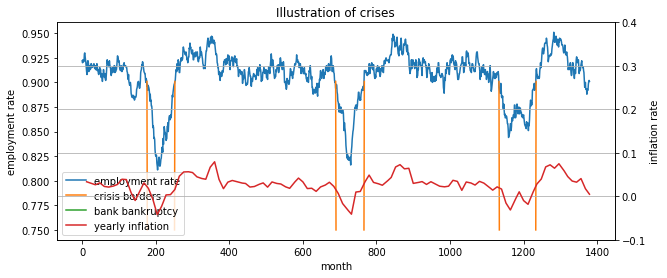

In [161]:
test.plot_recs(scenarios = [0], countries = [[0]], sims = [2], titles = [[["Illustration of crises"]]], #'2_24_24_BB_final_base_free_1'
              path = "d:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\crises_illustration.png")

In [183]:
%cd "d:\moje_dokumenty\Desktop\diplomka\model\data\chosen"

d:\moje_dokumenty\Desktop\diplomka\model\data\chosen


In [37]:
import glob

In [124]:
files = glob.glob('d:\moje_dokumenty\Desktop\diplomka\model\\data\\hdf_final\\*')#text parts\\tables\\BB base free; 1C _0')

In [29]:
test_load = Load_analysis(2, "BB_final_base_free_", 4,
                        scenario_names = ["base-base","alt1-alt1", "base-alt1"], limit = 5, variables = "all")

In [30]:
test = Analysis(test_load)

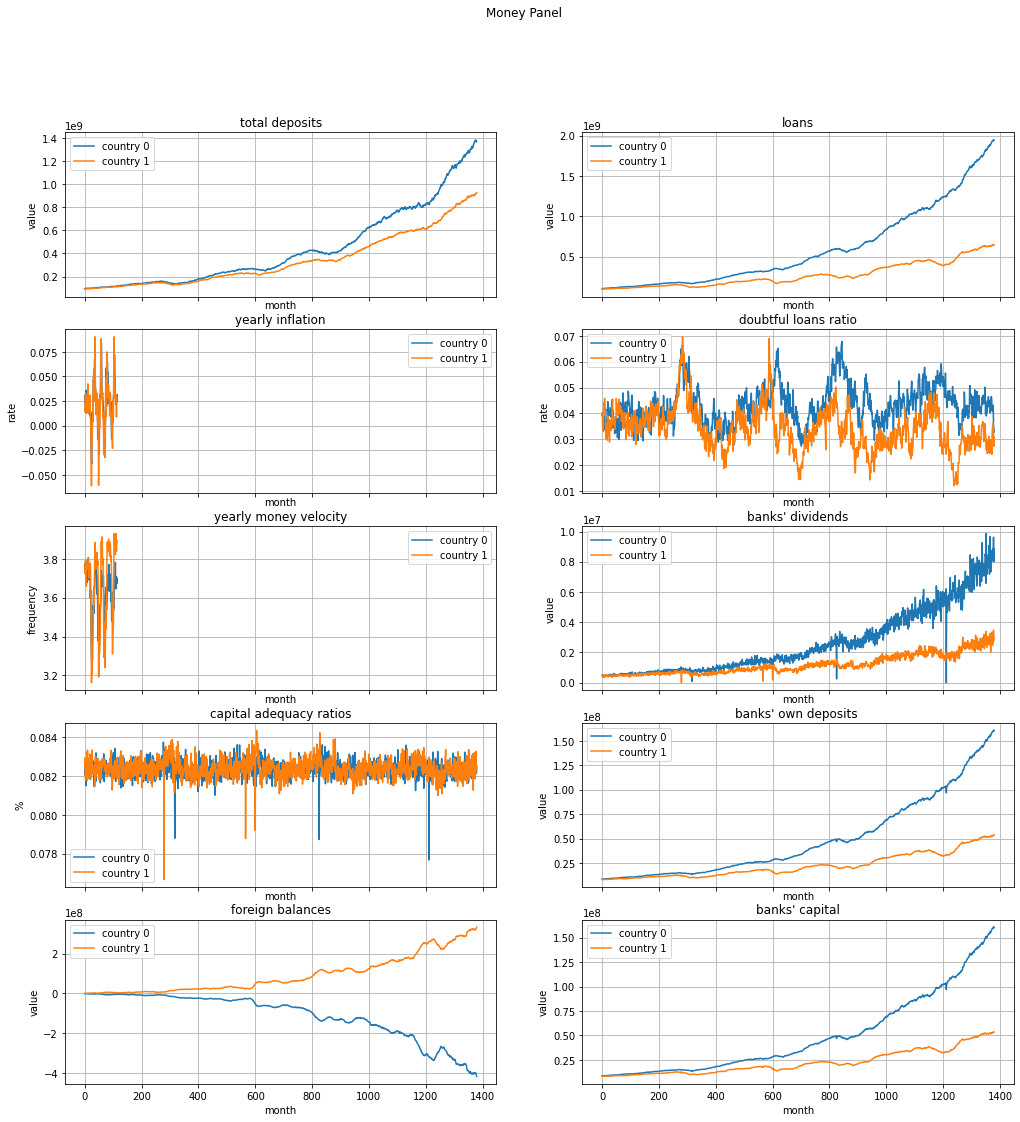

In [38]:
panel(test.data_list[2][0], name = "money")

In [31]:
test.test_parameters()

[]

In [32]:
test.analyze_all()

C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
test.corrs_table(["BC metric", "BC metric avg","BC metric 0"])

name: d:\moje_dokumenty\Desktop\diplomka\model\text parts\tables\BB base free _corrs.tex
\begin{table}
\centering
\caption{BB base free  summary of correlation coefficients}
\begin{tabular}{lrrrrr}
\toprule
        variables &   mean &    min &  median &    max &    std \\
\midrule
    base-base & & & & & \\
 \midrule
    BCsync metric & 0.7836 & 0.6324 &  0.8222 & 0.8594 & 0.0801 \\
BCsync metric avg & 0.8209 & 0.7193 &  0.8380 & 0.9024 & 0.0637 \\
  BCsync metric 0 & 0.8281 & 0.7904 &  0.8275 & 0.8627 & 0.0274 \\
\bottomrule
alt1-alt1 & & & & & \\
 \midrule
    BCsync metric & 0.8042 & 0.6853 &  0.7781 & 0.9392 & 0.0984 \\
BCsync metric avg & 0.8480 & 0.7724 &  0.8495 & 0.9426 & 0.0679 \\
  BCsync metric 0 & 0.8676 & 0.7217 &  0.8968 & 0.9392 & 0.0777 \\
\bottomrule
base-alt1 & & & & & \\
 \midrule
    BCsync metric & 0.6662 & 0.3880 &  0.7094 & 0.8596 & 0.1544 \\
BCsync metric avg & 0.7427 & 0.5144 &  0.7411 & 0.9065 & 0.1293 \\
  BCsync metric 0 & 0.8192 & 0.6409 &  0.8229 & 0.9533

In [46]:
for scen in test.data_list:
    for sim in scen:
        sim["empl_diffs"] = Special_TS("empl_diffs")
        sim["empl_diffs"].data = np.diff(sim["employment"].means())

In [86]:
test.export_tables(corrs_only = True)

name: d:\moje_dokumenty\Desktop\diplomka\model\text parts\tables\BB base free _1\BB base free empl_BC_sync_corrs.tex


In [117]:
test.analyze_recs( recs_percentile = 25,recs_cond = 0.03)

In [32]:
test.make_global_crises()

In [496]:
test.make_stab_data_list( variables = ["employment", "wages", "total_trade_balances_m"])

In [497]:
test.make_stab_data_list( variables = ["employment", "wages", "total_trade_balances_m"], crises = 1)

In [148]:
test.get_averages()

C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [500]:
test.get_averages(data = 1)

In [514]:
test.stats_table("total_trade_balances_m", data = 2,caption = "dnakj")

name: d:\moje_dokumenty\Desktop\diplomka\model\text parts\tables\BB base free total_trade_balances_m.tex
\begin{table}
\centering
\caption{dnakj}
\begin{tabular}{lrrrr|rr}
\toprule
{} &    min &   mean &     max &  std of mean &  inner std &  std of inner std \\
\midrule
base-base & & & & & & \\
 \midrule
country 0 & -374.2 &  697.2 &  2003.0 &       765.18 &    5287.34 &            486.05 \\
country 1 &  104.7 &  784.7 &  1240.6 &       379.07 &    5484.22 &            101.42 \\
\bottomrule
alt1-alt1 & & & & & & \\
 \midrule
country 0 &   229.2 &  833.4 &  1488.6 &       474.78 &    4814.62 &            633.17 \\
country 1 & -1063.2 &  441.1 &  1489.1 &       866.41 &    5167.10 &            596.53 \\
\bottomrule
base-alt1 & & & & & & \\
 \midrule
country 0 & -194510.0 &  -96670.0 &   86250.0 &     104601.0 &   554635.0 &           41930.0 \\
country 1 &  181640.0 &  258980.0 &  336670.0 &      58020.0 &   540929.0 &           30406.0 \\
\bottomrule
\end{tabular}
\label{tab:BB base fr

In [515]:
test.quick_stats_table("hsh_sentiment", data = 1, crises = 0,caption = "dnakj")

name: d:\moje_dokumenty\Desktop\diplomka\model\text parts\tables\BB base free  stability hsh_sentiment.tex
\begin{table}
\centering
\caption{dnakj}
\begin{tabular}{lrrrr|rr}
\toprule
{} &    min &   mean &    max &  std of mean &  inner std &  std of inner std \\
\midrule
base-base & & & & & & \\
 \midrule
country 0 &  72.26 &  72.78 &  73.25 &         0.34 &       3.18 &              0.36 \\
country 1 &  72.43 &  72.82 &  73.27 &         0.28 &       3.12 &              0.28 \\
\bottomrule
alt1-alt1 & & & & & & \\
 \midrule
country 0 &  68.13 &  69.28 &  69.99 &         0.70 &       7.47 &              1.58 \\
country 1 &  68.04 &  69.64 &  70.52 &         0.89 &       7.17 &              1.52 \\
\bottomrule
base-alt1 & & & & & & \\
 \midrule
country 0 &  70.63 &  71.73 &  72.49 &         0.64 &       3.96 &              0.74 \\
country 1 &  71.16 &  71.75 &  72.40 &         0.45 &       4.12 &              0.78 \\
\bottomrule
\end{tabular}
\label{tab:BB base free  stability hsh senti

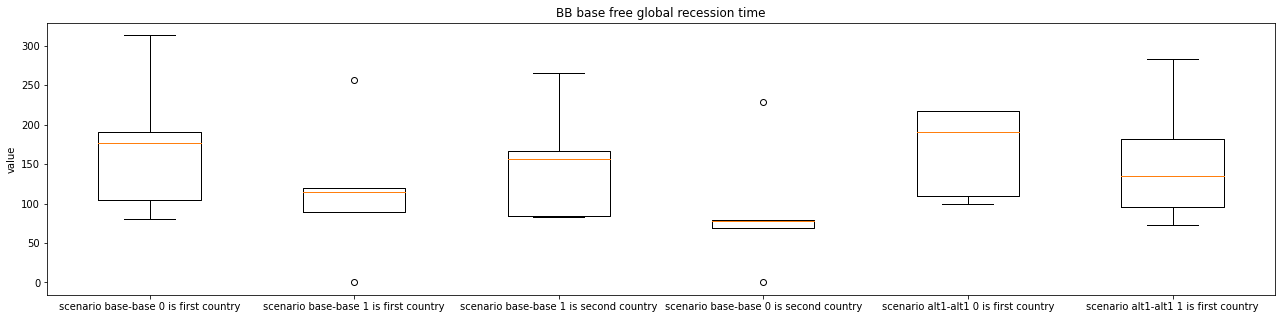

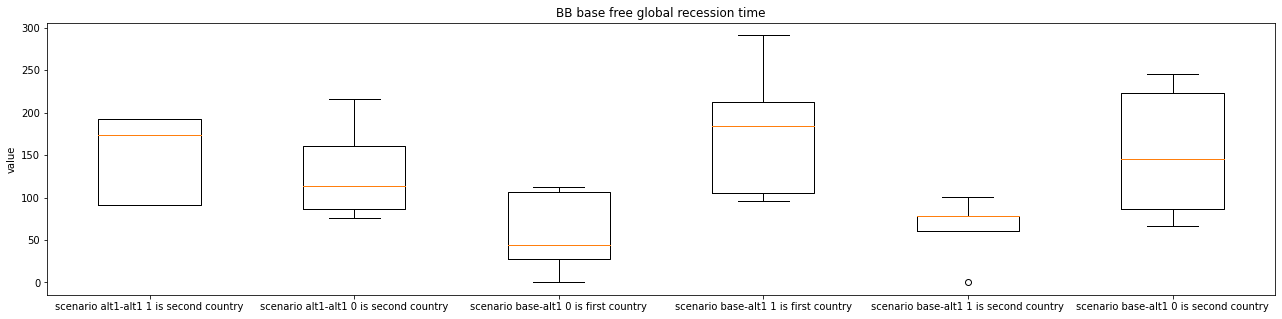

In [28]:
test.recs_whiskers( global_crises = 1, measure = "time", piecewise = 1, size = (22,5))

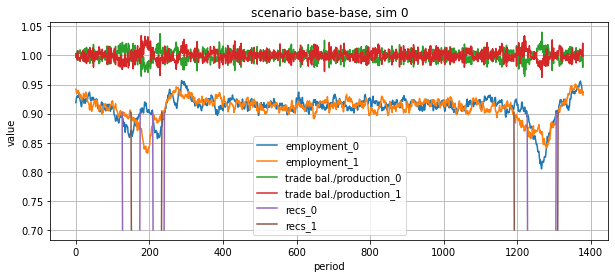

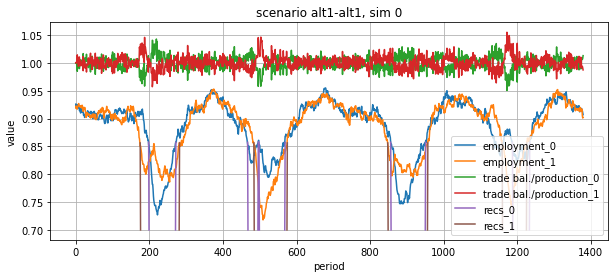

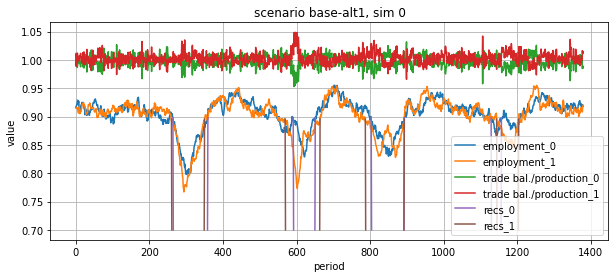

In [29]:
test.plot_trading()

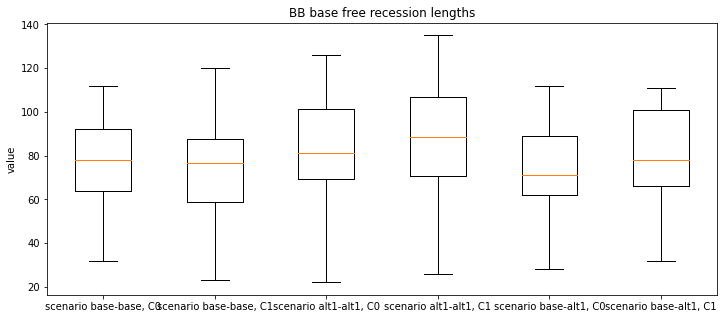

In [30]:
test.recs_whiskers()

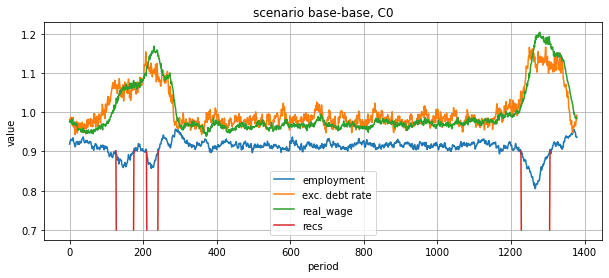

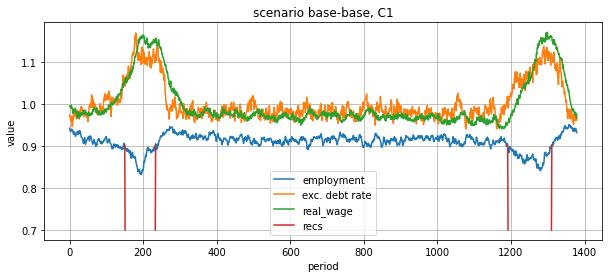

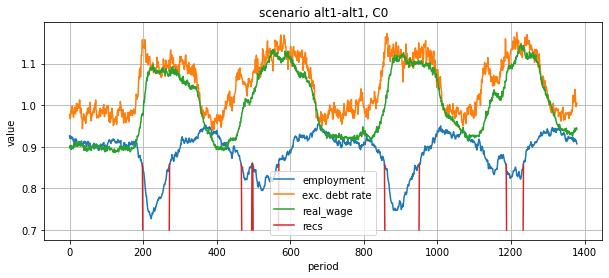

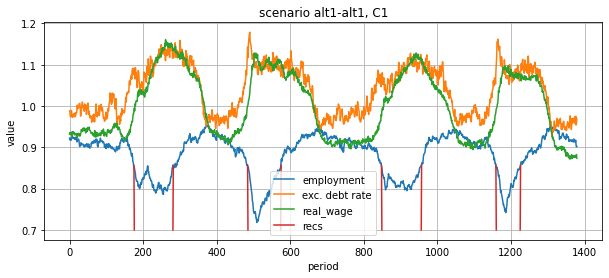

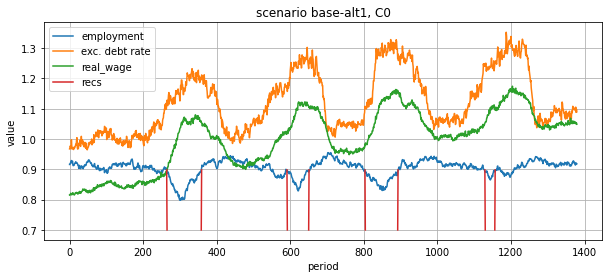

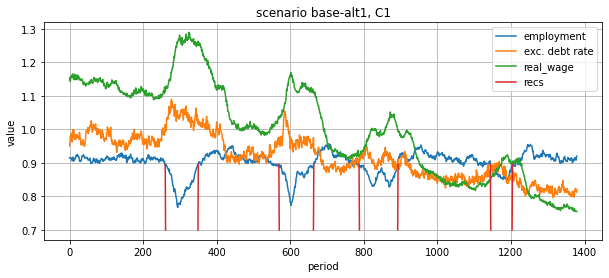

In [31]:
test.plot_recovery(y_lim = 0.7 )

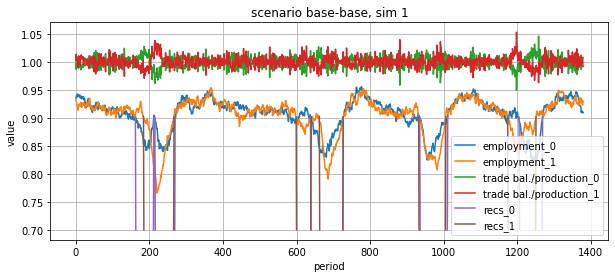

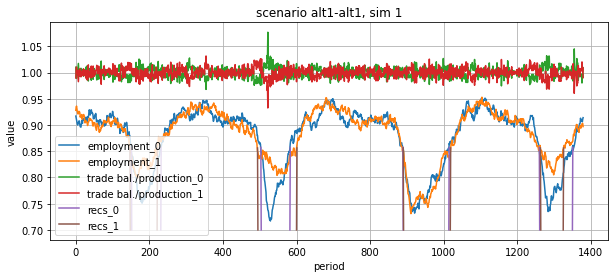

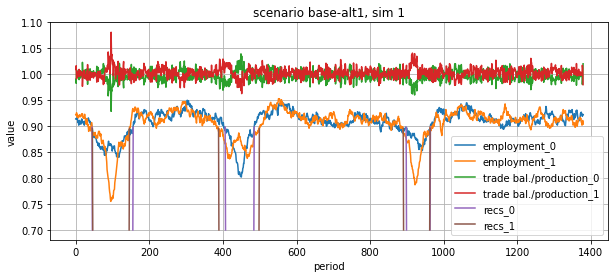

In [32]:
test.plot_trading(sims = [1])

In [33]:
test.get_averages()

C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [307]:
test.export_tables()

In [308]:
test.averages["employment"]

([[0.9061, 0.9049], [0.877, 0.8762], [0.9039, 0.9001]],
 [[0.9075, 0.907], [0.884, 0.8846], [0.9059, 0.9028]],
 [[0.9111, 0.91], [0.89, 0.8915], [0.9076, 0.9054]],
 [[0.00189, 0.00192], [0.00581, 0.00557], [0.00123, 0.00207]],
 [[0.02562, 0.0285], [0.05071, 0.04986], [0.02601, 0.03035]],
 [[0.0030298, 0.0052833], [0.0067119, 0.0045369], [0.0019579, 0.0028898]])

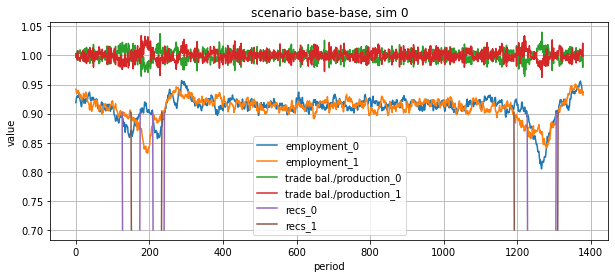

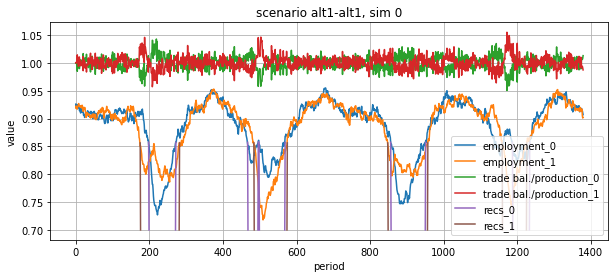

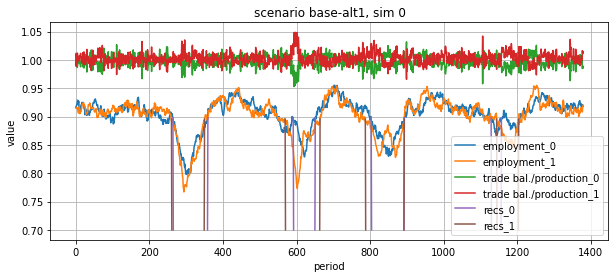

In [309]:
test.plot_trading()

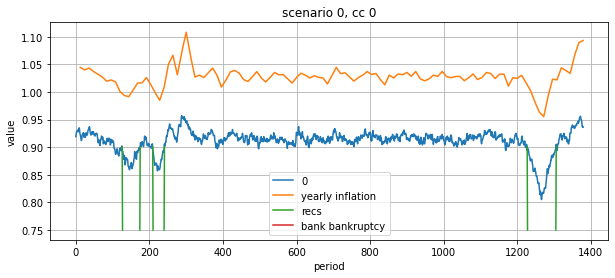

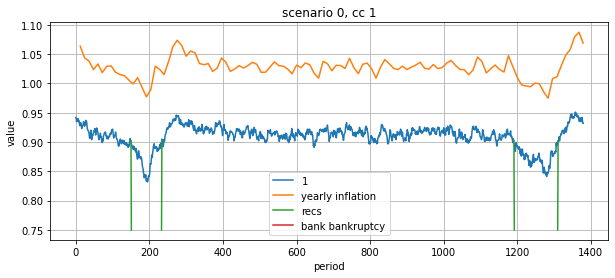

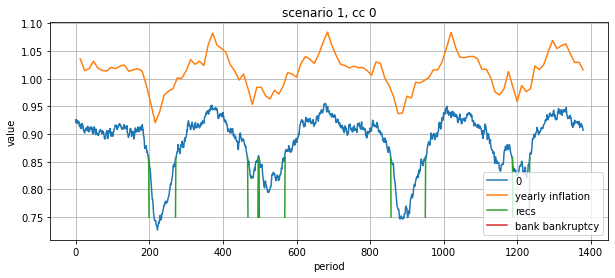

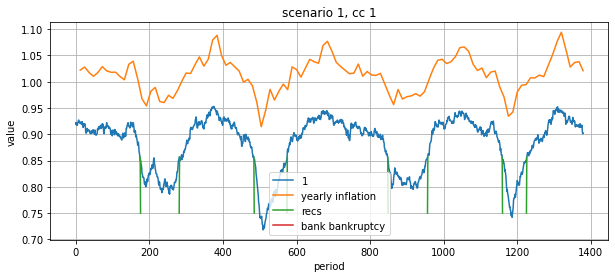

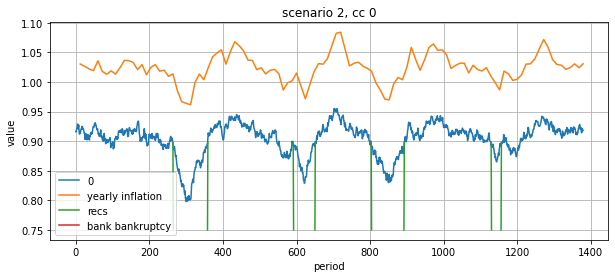

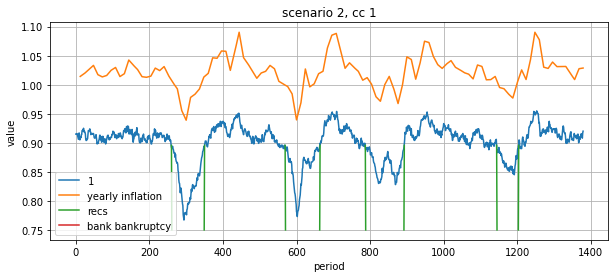

In [310]:
test.plot_recs()

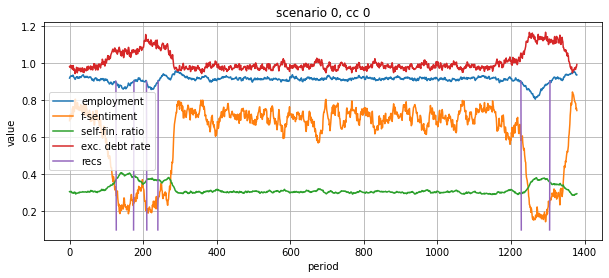

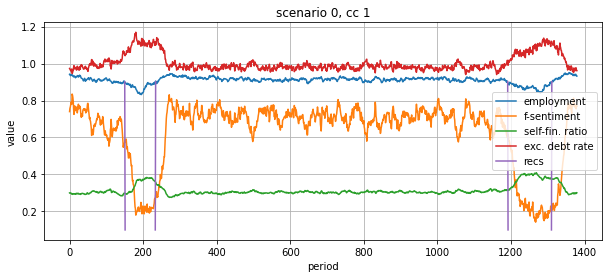

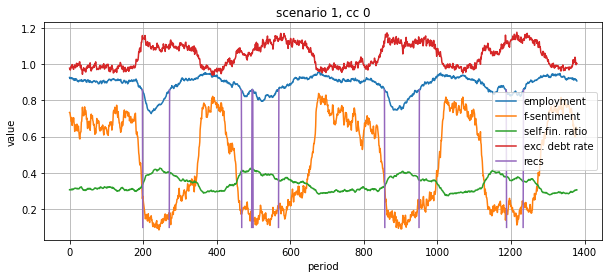

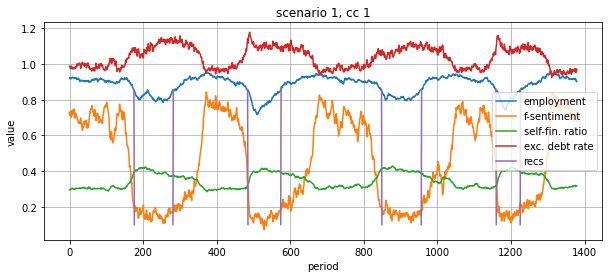

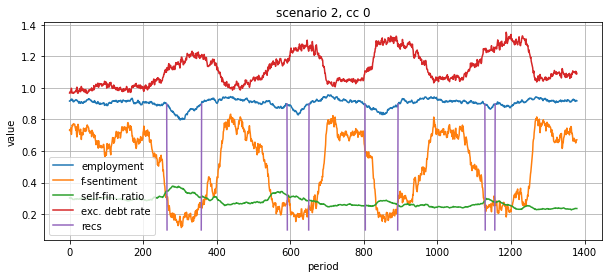

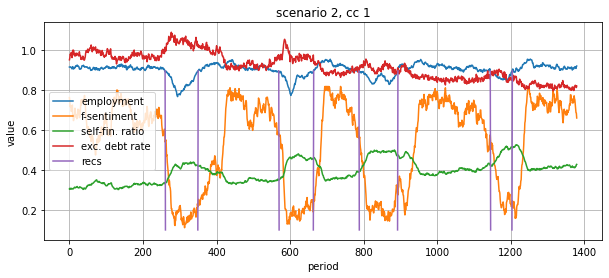

In [311]:
test.plot_deleveraging()

In [312]:
scenario = 0
country = 0
simulation = 0

In [313]:
simulation += 1
simulation

1

In [314]:
low, sts, ends  = test.empl_data[scenario][0][simulation][:3]
low2, sts2, ends2  = test.empl_data[scenario][1][simulation][:3]

In [316]:
from model_tools import periodize

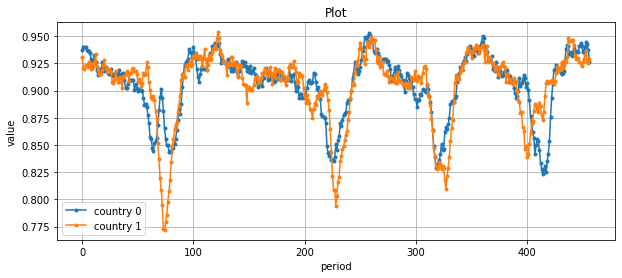

In [317]:
plot(periodize(test.data_list[scenario][simulation]["employment"].means(), perioda = 3, averaging = True), marker = ".-", zipping = True)

In [19]:
low_1 = np.mean([np.percentile(sim["employment"].means()[0], 25) for sim in C1_final_cut_1])

In [20]:
low_2 = np.mean([np.percentile(sim["employment"].means()[0], 25) for sim in C1_final_cut_2])

In [21]:
i += 3
i

3

In [22]:
low, sts, ends, dpts, lns = find_recs(C1_final_cut_2[i]["employment"].means()[0], low = low_2)

In [76]:
from model_tools import differences, growths, ratios

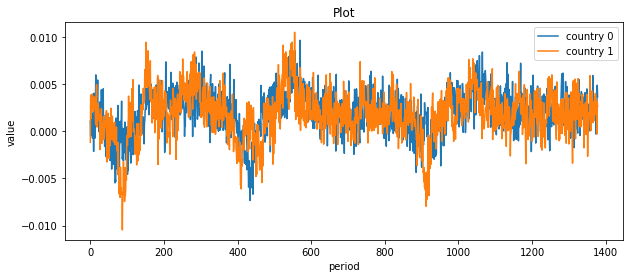

In [324]:
plot(growths(test.data_list[0][1]["prices"].means(), rate=True), #+[np.zeros(440)]
     marker = "-", zipping=True) 

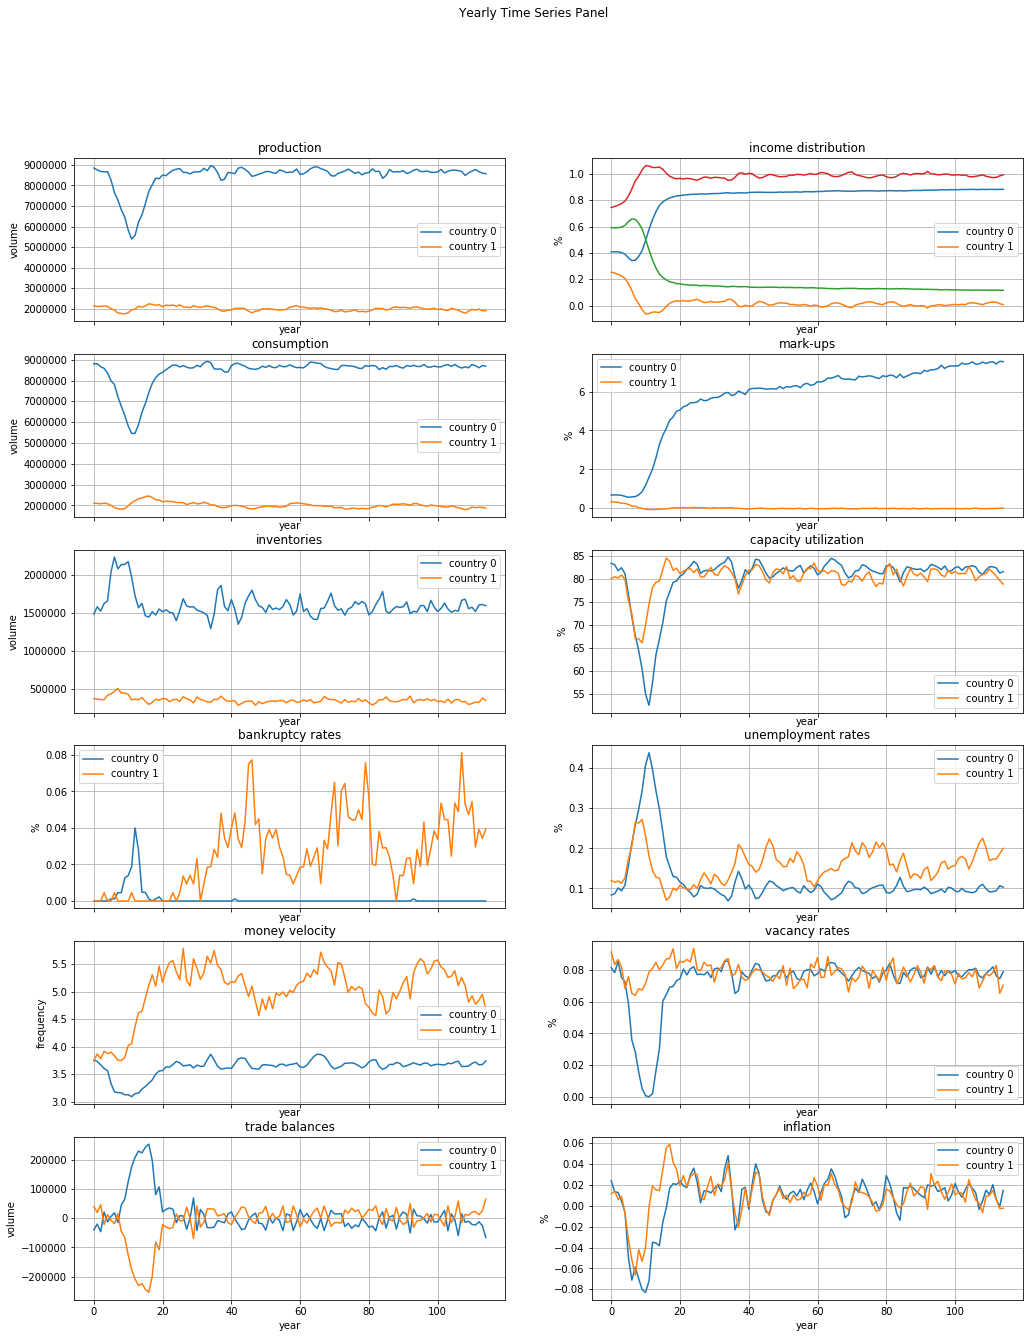

In [74]:
panel(test.data_list[0][5], name = pans[3])

In [83]:
rr = "fnka"
rr = rr.replace("n","ak")
rr

'fakka'

# 1 country

In [19]:
C1_load = Load_analysis(1, "1C_final_", 4, scenario_names = ["base", "alt", "extr_alt"])

In [20]:
C1 = Analysis(C1_load)

In [21]:
C1.test_parameters([{"ns": [5000], "ms": [550], "wage_resist": [12], "wage_flex": [0.05]},
                   {"ns": [5000], "ms": [550], "wage_resist": [8], "wage_flex": [0.08]},
                   {"ns": [5000], "ms": [550], "wage_resist": [8], "wage_flex": [0.25]}])

[]

In [22]:
C1.analyze_all()

In [26]:
C1.export_tables()

In [28]:
pp = C1.base_path

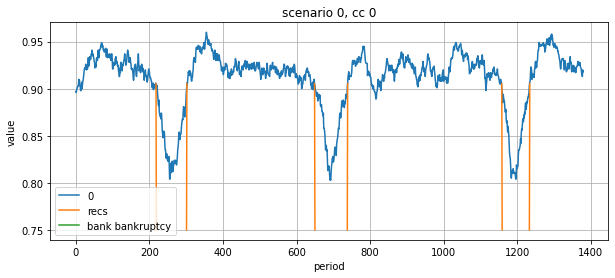

In [29]:
C1.plot_recs(scenarios = [0], sims = [4], path = pp + "\\recs_ex.jpg")

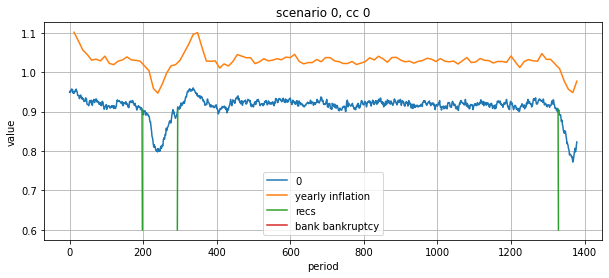

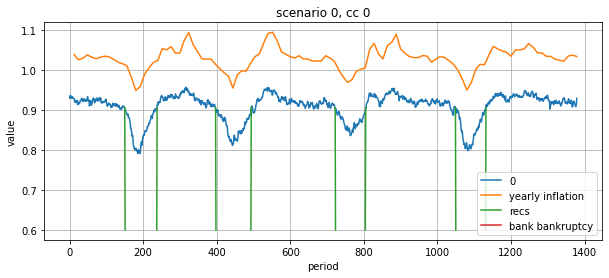

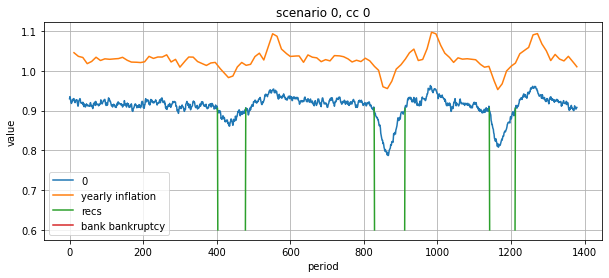

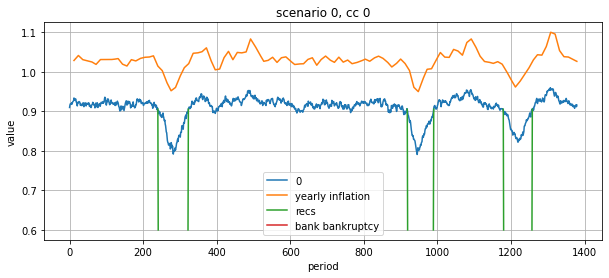

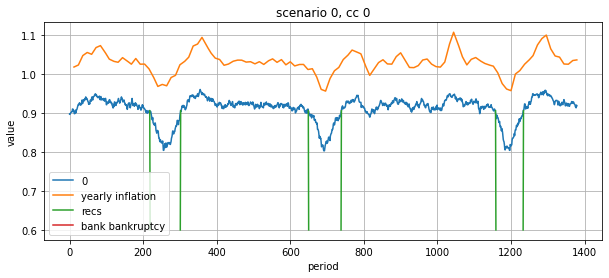

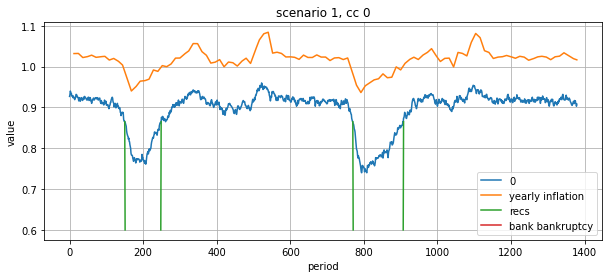

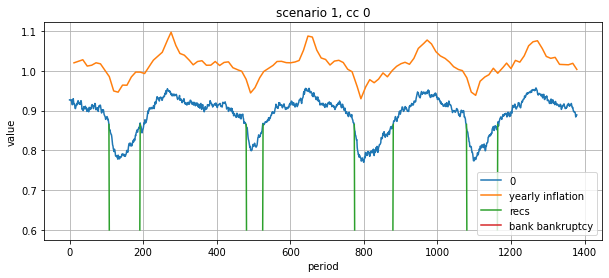

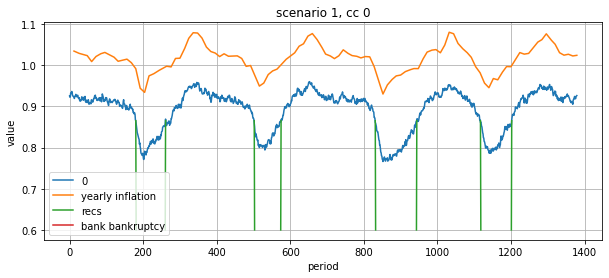

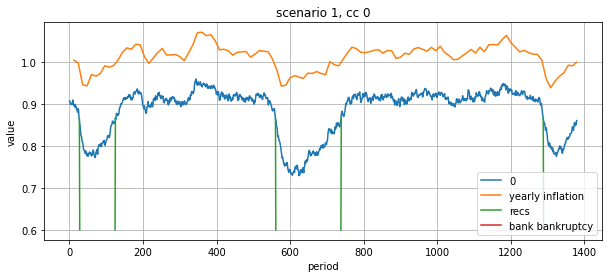

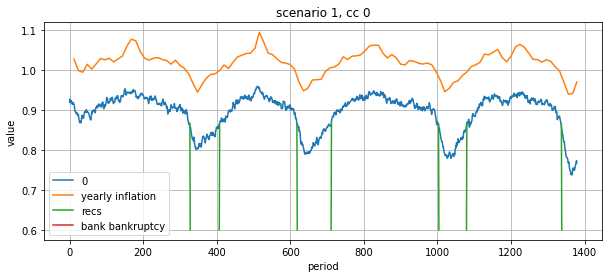

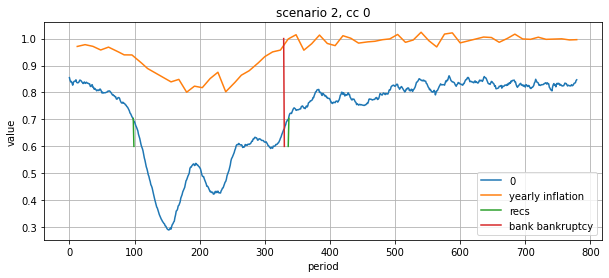

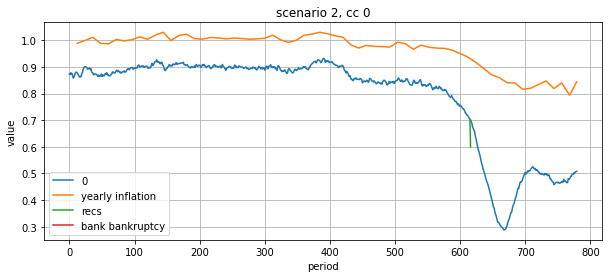

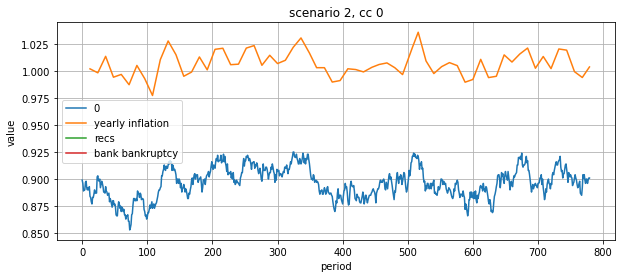

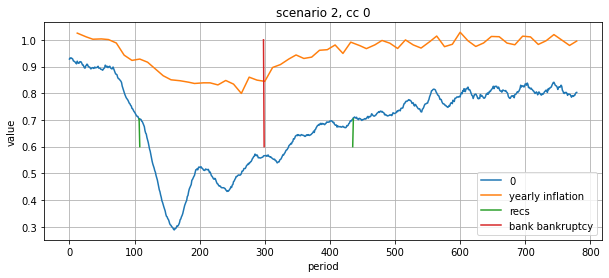

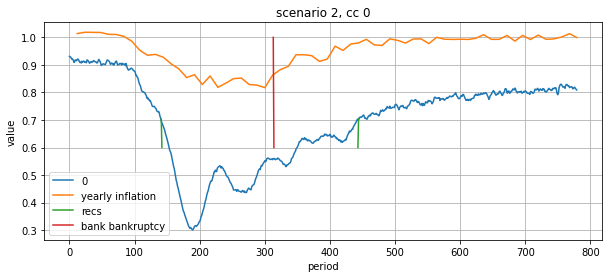

In [23]:
C1.plot_recs(sims=[0,1,2,3,4], y_lim=0.6)

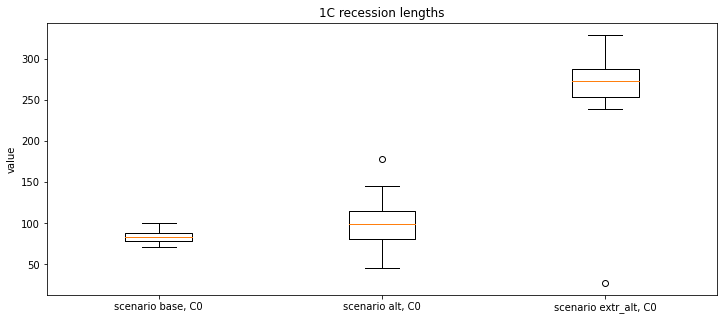

In [24]:
C1.recs_whiskers()

<ipython-input-18-92ca98a69d6b>:318: RuntimeWarning: invalid value encountered in true_divide
  export_rate = np.array(exports)/np.mean(exports)
<ipython-input-18-92ca98a69d6b>:321: RuntimeWarning: invalid value encountered in true_divide
  import_rate = np.array(imports)/np.mean(imports)
<ipython-input-18-92ca98a69d6b>:323: RuntimeWarning: invalid value encountered in true_divide
  tbs_rate = np.array(tbs)/np.mean(np.abs(tbs))


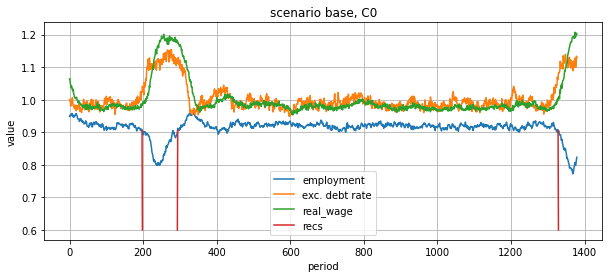

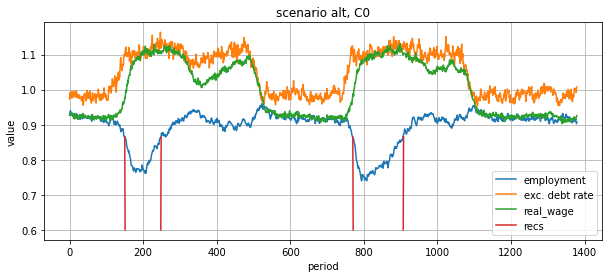

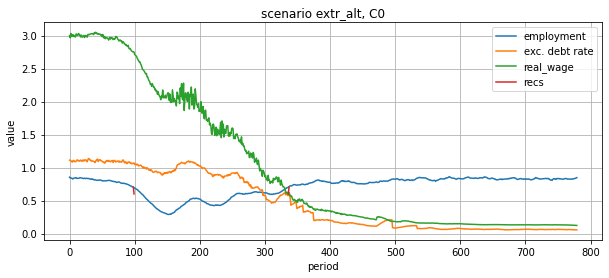

In [25]:
C1.plot_recovery()

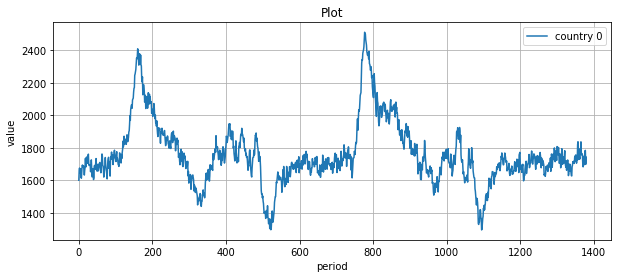

In [28]:
plot(C1.data_list[1][0]["inventories"].means())

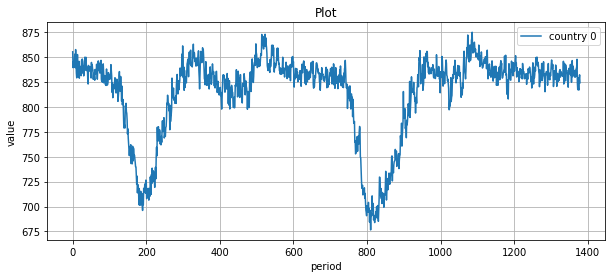

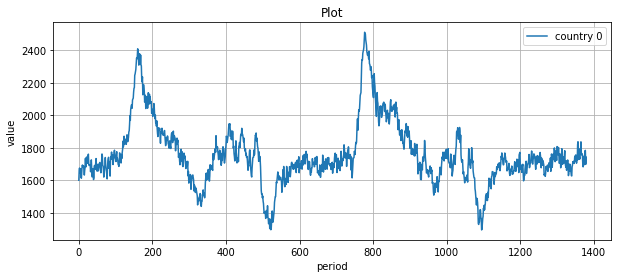

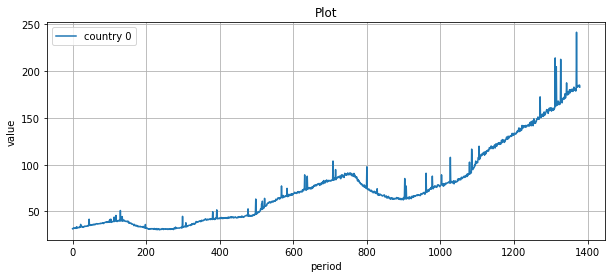

In [29]:
plot(C1.data_list[1][0]["sales"].means()) 
plot(C1.data_list[1][0]["inventories"].means())
plot(C1.data_list[1][0]["forced_savings"].means())

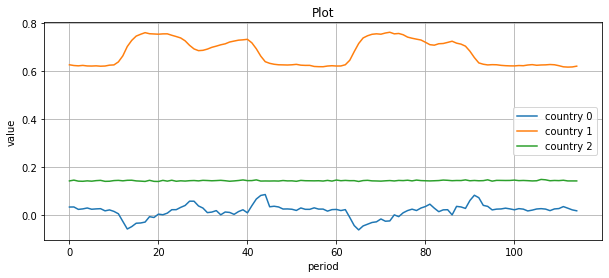

In [107]:
plot(C1.data_list[1][0]["inflation_y"] + C1.data_list[1][0]["wage_share_y"]+ C1.data_list[1][0]["hoarding_m"])

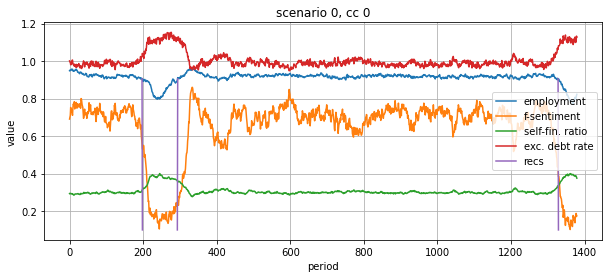

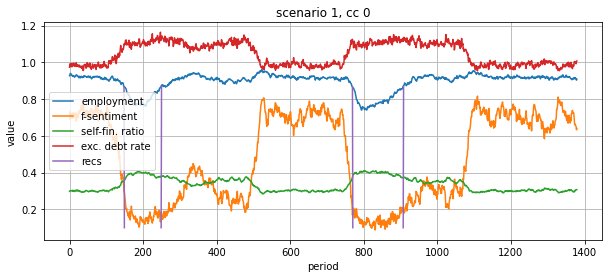

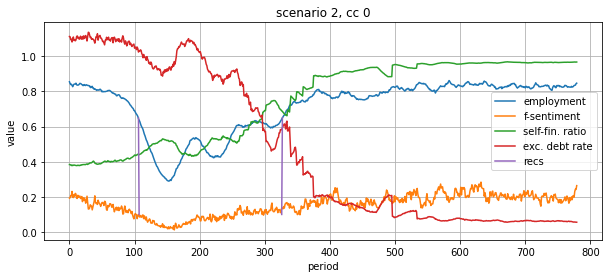

In [89]:
C1.plot_deleveraging()

In [109]:
C1.averages["mean_real_wage_m"]

([[64.7], [66.0], [18.8]],
 [[66.8], [68.5], [37.1]],
 [[68.7], [70.5], [72.5]],
 [[0.9611], [0.87825], [19.94]],
 [[4.84], [5.24], [19.65]],
 [[0.4775858], [0.2707955], [8.58]])

In [31]:
C1.make_correlations("excessive_debt_rate_m", "employment", type1 = "data", type2 = "means", across=0, save=1)

([array([[-0.7591, -0.6191, -0.6119, -0.5713, -0.5367, -0.6984, -0.7124,
          -0.6628, -0.6963, -0.7308, -0.6783, -0.7156, -0.6898, -0.6623,
          -0.632 , -0.6892, -0.659 , -0.5086, -0.625 , -0.6576, -0.6043,
          -0.6649, -0.6653, -0.6211, -0.6079, -0.654 , -0.5093, -0.6085,
          -0.6068, -0.7257, -0.6625]]),
  array([[-0.5259, -0.657 , -0.6866, -0.4168, -0.5757, -0.6582, -0.7095,
          -0.6855, -0.5623, -0.6404, -0.4878, -0.5843, -0.6986, -0.4881,
          -0.6836, -0.6534, -0.5731, -0.6692, -0.4823, -0.5112, -0.6646,
          -0.6721, -0.6205, -0.4508, -0.5341, -0.6266, -0.526 , -0.5482,
          -0.6515, -0.6162, -0.6993]]),
  array([[-0.6258,  0.8671,  0.0147, -0.4506, -0.3415, -0.0827,  0.6393,
           0.1395, -0.4733, -0.1751, -0.7471, -0.5136, -0.5282, -0.5314,
          -0.4351,  0.3077, -0.336 , -0.6136, -0.4081,  0.408 , -0.2635,
          -0.5525, -0.5102, -0.4442, -0.3638, -0.5877, -0.3477, -0.503 ,
           0.2607,  0.4759, -0.4699]])],
 [[

In [9]:
pans

{0: 'main',
 1: 'sentiments',
 2: 'int_trade',
 3: 'yearly',
 4: 'money',
 5: 'labor',
 6: 'profits',
 7: 'industry',
 8: 'cons',
 9: 'cycles'}

In [31]:
j = 0

In [11]:
j += 1
j

1

In [12]:
i = 0

In [ ]:
i += 1
i

In [48]:
def plot_deleveraging(data_dict, country = 0):
    plot([data_dict["employment"].means()[country]] + [data_dict["firm_sentiment"].means()[country]] 
         + [data_dict["self_financing_ratio_m"][country]] + [data_dict["excessive_debt_rate_m"][country]] ,
        legend = ["employment", "f-sentiment", "self-fin. ratio", "exc. debt rate"])
    

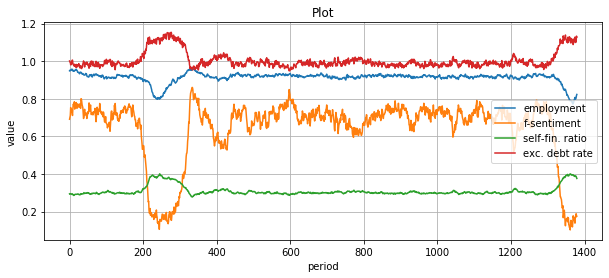

In [50]:
plot_deleveraging(C1.firsts[0])

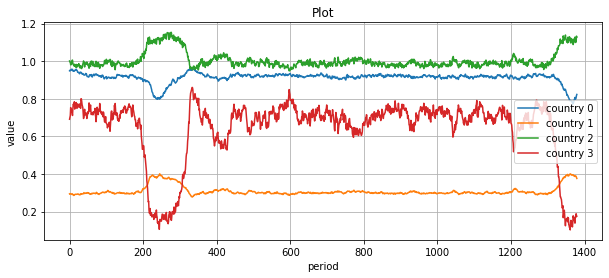

In [47]:
plot(C1.firsts[0]["employment"].means() + C1.firsts[0]["self_financing_ratio_m"] + 
     C1.firsts[0]["excessive_debt_rate_m"] + C1.firsts[0]["firm_sentiment"].means())

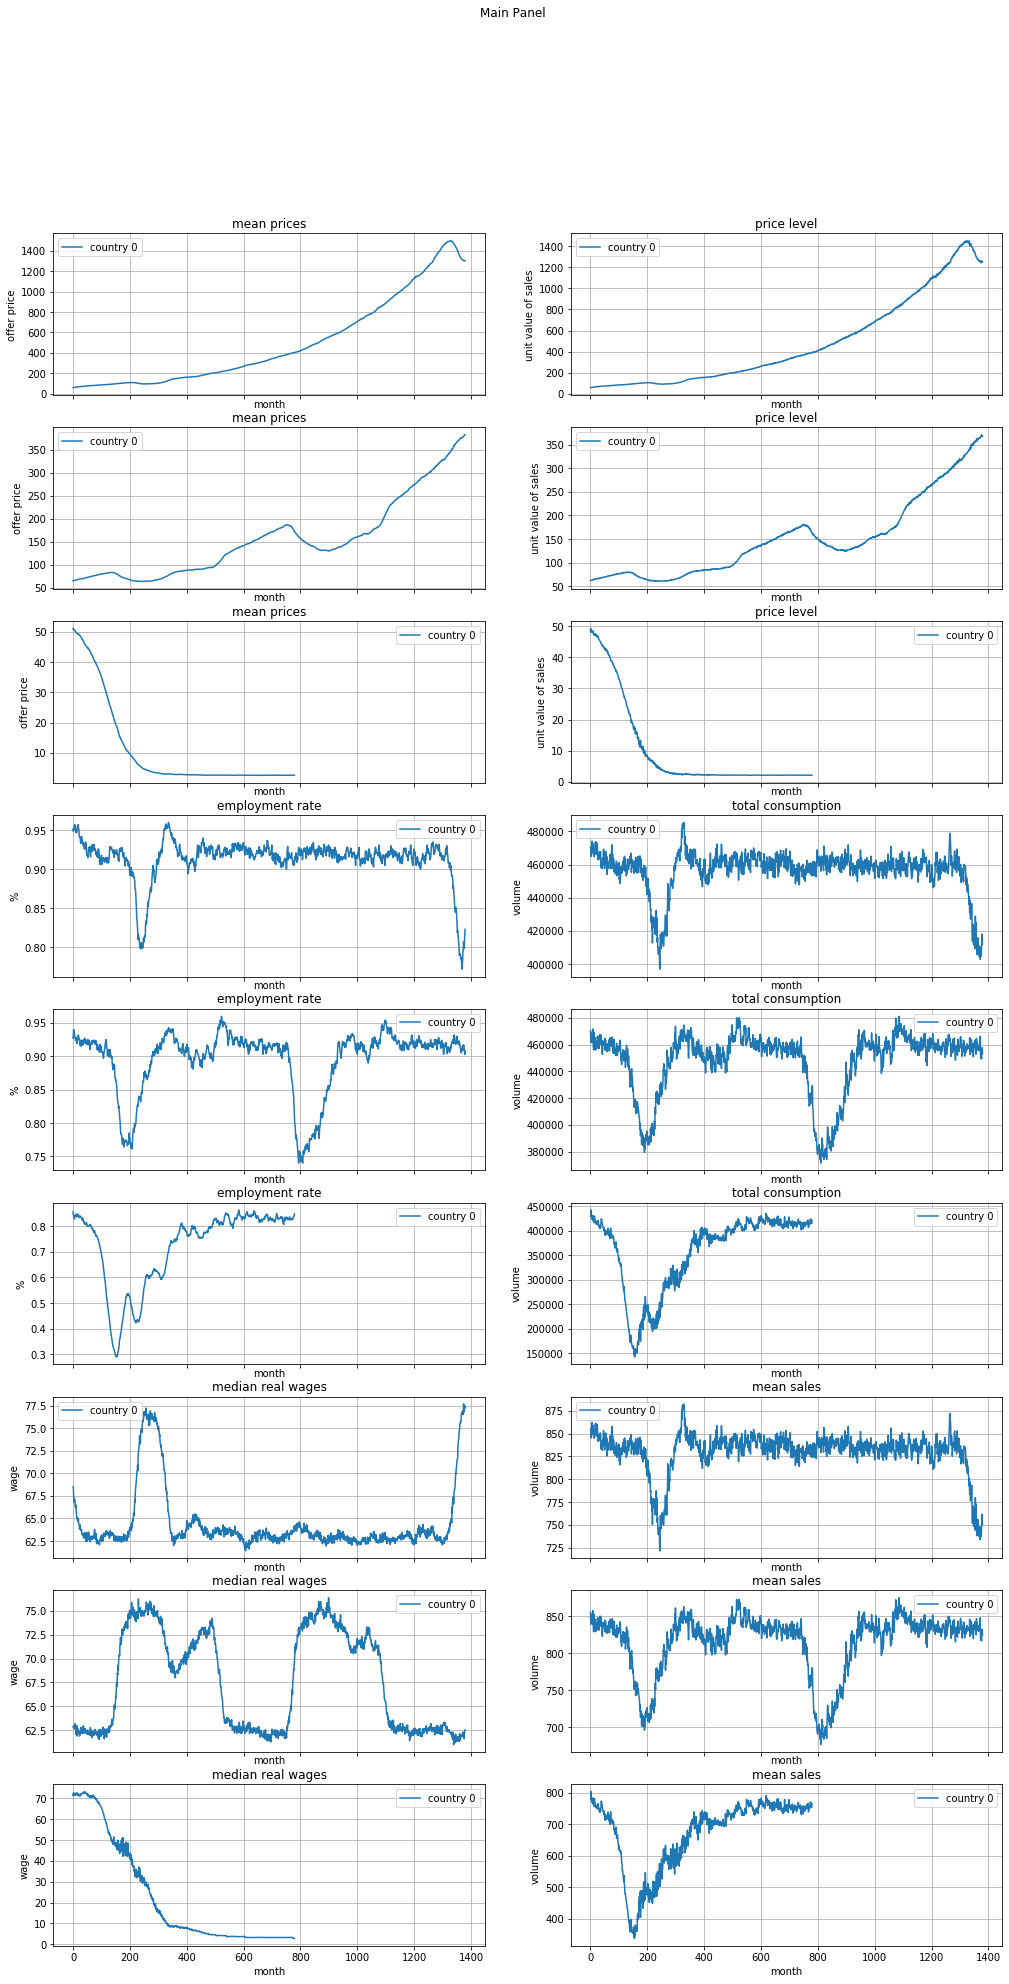

In [32]:
panel(*C1.firsts, name = panels[j])

In [492]:
import model_tools 

Sim = model_tools.Simulation
experiment = model_tools.experiment
random = model_tools.random
np = model_tools.np
exp_grid = model_tools.exp_grid
make_matrix = model_tools.make_matrix
make_grid = model_tools.make_grid
set_base_pars = model_tools.set_base_pars

In [493]:
set_base_pars([5000,5000])   


grid = [ ([12]*model_tools.no_countries ,[0.05]*model_tools.no_countries),   # baseline
       ([8]*model_tools.no_countries ,[0.08]*model_tools.no_countries),      # alt 1
       ([12, 8]   ,[0.05, 0.08] ),                                           # base - alt 1
       ([12, 8]   ,[0.05, 0.25] )]    

In [494]:
model_tools.free_market = False
model_tools.quotas = make_matrix(0.05, False)
model_tools.wage_resist = [12, 8] 
model_tools.wage_flex = [0.05, 0.08]

In [ ]:
"2_18165_7192_BB_final_base_low_3.h5"

In [497]:
experiment([[18165, 7192]], 1500, "BB_final_base_low_3", hdf = True, csv = False)

C:\Users\am\model_tools.py:1862: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
C:\Users\am\model_tools.py:1842: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
C:\Users\am\model_tools.py:1862: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))
C:\Users\am\model_tools.py:2137: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['employment', 'wages', 'working_wages', 'vol_unemployed', 'months_u',
       'unemployed_months_u', 'hsh_sentiment', 'hsh_income', 'savings_T',
       'budget', 'cons', 'cons_value', 'forced_savings', 'hsh_deposits',
       'prices', 'offered_wages', 'production', 'production_value',
       'labor_demand', 'labor', 'job_offers', 'vacancies', 'inventories',
       'sales', 'sales_value', 'sales_costs',

# odpad

In [21]:
class crisis_old:
    """For 2 countries models, returns data on global crises."""
    
    def popping(self, ll):
        try:
            ee = ll.pop(0)
        except:
            ee = "nothing"
        return ee
    
    def __init__(self, empl_data_c0, empl_data_c1):
        """Includes info on start and end of union and intersection of crises, which country is first, lengths, depths."""
        first_countries = []       # which country is first in recession
        union_periods = []         # at least one country in crises
        intersection_periods = []  # both countries in crisis
        first_depths, first_lengths  = [], []
        second_depths, second_lengths = [], []
        contained_crises = 0
        popping = self.popping
    
        sts_1, sts_2 = empl_data_c0[1].copy(), empl_data_c1[1].copy()
        ends_1, ends_2 = empl_data_c0[2].copy(), empl_data_c1[2].copy()
        depths = [empl_data_c0[3].copy(), empl_data_c1[3].copy()]
        lengths= [empl_data_c0[4].copy(), empl_data_c1[4].copy()]
    
        start_1, start_2 = None, None
        print(ends_1, ends_2)
        while sts_1+sts_2 != []:
            if start_1 is None:
                start_1 = popping(sts_1)
            if start_2 is None:
                start_2 = popping(sts_2) 
            
            print(start_1, start_2)
        
            if start_1 == "nothing" or start_2 == "nothing":
                break
        
            if start_1 <= start_2:
                first_c = 0
                second_start = start_2
                end = popping(ends_1)
                first_start = start_1
                start_1 = None          # we have used this start
            else:
                first_c = 1
                second_start = start_1
                end = popping(ends_2)
                first_start = start_2
                start_2 = None          # we have used this start
        
            print("end:", end) 
            print(ends_1, ends_2)
            if end == "nothing":        # crises are intersecting at the end of simulation, ignore them
                break
           
            elif end > second_start:         # crises are intersecting
                print("intering")
                end_2 = popping(ends_1) if first_c == 1 else popping(ends_2)  
                start_1, start_2 = None, None
                if end_2 == "nothing":   # global crisis at the end of simulation, ignore it
                    break
                
                total_end = max([end, end_2])
                partial_end = min([end, end_2])
                
                first_countries.append(first_c)
                union_periods.append((first_start, total_end))
                intersection_periods.append((second_start, partial_end))
                
                first_depths.append(depths[first_c].pop(0))
                second_depths.append(depths[-(first_c-1)].pop(0))
                first_lengths.append(lengths[first_c].pop(0))
                second_lengths.append(lengths[-(first_c-1)].pop(0))
                    
            else:
                contained_crises += 1
                depths[first_c].pop(0)
                lengths[first_c].pop(0)
            
            print(contained_crises)
            
        contained_crises += len(ends_1 + ends_2)
        self.first_countries = first_countries
        self.union_periods = union_periods
        self.intersection_periods = intersection_periods
        self.depths = (first_depths, second_depths)
        self.lengths = (first_lengths, second_lengths)
        self.contained_crises = contained_crises 
    
    def show(self):
        attrs = [
            self.first_countries,
            self.union_periods,
            self.intersection_periods,
            self.depths,
            self.lengths,
            self.contained_crises
        ]
        return attrs